# 1. Introduksjon og Klinisk Kontekst
Brystkreft er den vanligste kreftformen blant kvinner i Norge, og den nest vanligste kreftformen i den norske befolkningen totalt sett, etter prostatakreft. I 2022 fikk omtrent 4200 kvinner i Norge diagnosen brystkreft [1].
I dette prosjektet skiller vi mellom to typer brystsvulster:
Godartet (Benign): Dette er ikke-kreftsyke svulster som vanligvis ikke sprer seg utover området der de oppsto.
Ondartet (Malign): Dette er kreftsvulster som kan invadere nærliggende vev og spre seg (metastaser) til forskjellige deler av kroppen, noe som potensielt kan ha alvorlige kliniske implikasjoner [1].
Dette prosjektet har som mål å utnytte dataanalyse for å undersøke korrelasjonen mellom ulike svulstegenskaper (som størrelse, overflateegenskaper og tekstur) og krefttypen (ondartet vs. godartet). Det endelige målet er å skape en prediksjonsmodell som kan vurdere sannsynligheten for at en brystsvulst er ondartet eller godartet basert på disse egenskapene.

# 2. Definisjon av Egenskaper og Hypoteser
Datasettet som brukes i dette prosjektet inneholder egenskaper utledet fra digitaliserte bilder av en finnålsaspirasjon (FNA) av brystsvulster. Disse egenskapene er gruppert i kategorier relatert til størrelse, overflateegenskaper og tekstur, som er avgjørende for kreftdiagnostikk.

2.1 Størrelsesegenskaper
RADIUS: Ble beregnet ved å ta gjennomsnittet av lengdene til radielle linjesegmenter fra sentrum av cellekjernen til punktene langs cellekjernens yttergrense.
PERIMETER: Ble målt som avstanden rundt cellekjernens grense.
AREAL: Ble målt ved å telle antall piksler innenfor cellekjernens grense og legge til halvparten av pikslene på omkretsen.

2.2 Overflateegenskaper
Disse egenskapene inkluderer variabler som glatthet, konkavitet og konkave punkter:

Glatthet: Ble kvantifisert ved å måle forskjellen mellom lengden på hver radius og gjennomsnittslengden av tilstøtende radier. Denne metrikken reflekterer den lokale variasjonen i radiuslengder, noe som indikerer jevnheten i cellekjernens omriss.
Konkavitet: Ble bestemt ved å måle størrelsen på eventuelle innbuktninger i cellekjernens ytterkant.
Konkave Punkter: Telte antall punkter på cellekjernens ytterkant som ligger i en innbuktning.
Hypotese: Det er en sammenheng mellom cellekjernens overflateegenskaper og krefttypen (ondartet vs. godartet).

2.3 Teksturegenskaper
Disse egenskapene inkluderer symmetri, fraktal dimensjon, tekstur og kompakthet:

Symmetri: Ble målt ved å finne den relative forskjellen i lengde mellom linjesegmenter som var vinkelrett på og på hver side av hovedaksen, noe som indikerer regelmessigheten i cellekjernens form.
Fraktal Dimensjon: Ble tilnærmet ved hjelp av "kystlinjeapproksimasjonen," som kvantifiserte uregelmessigheten eller kompleksiteten i cellekjernens yttergrense.
Tekstur: Ble målt ved å finne variansen i gråtoneintensitetene i de enkelte pikslene i cellekjernen, noe som reflekterer jevnheten eller ruheten i teksturen.
Kompakthet: Kombinerte omkrets og areal, ved hjelp av formelen: omkrets^2 / areal. Dette ga et mål på hvor kompakt cellekjernens materiale var arrangert.
Hypotese: Det er en sammenheng mellom svulstens teksturegenskaper og krefttypen (ondartet vs. godartet).


[1] Folkehelseinstitutet (https://www.fhi.no/he/folkehelserapporten/ikke-smittsomme/kreft/?term=#om-kreft)

# 3. Import av Data og Innledende Utforskning

### 3.1 Bibliotekoppsett


Jeg importerer de nødvendige Python-bibliotekene for dataanalyse visualisering og maskinlæring:

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Datahåndtering og -spørring(grunnleggene SQL-spørringer)
import duckdb 


# Maskinlæring - Modeller og Verktøy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Maskinlæring - Metrikker
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, auc

# Statistisk Analyse
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

### 3.2  Datainnlasting

In [8]:
df_kreft = pd.read_csv('data/kreft_dataset.csv')

Dataset og nødvendige bibliotekene er nå klare. Jeg fortsetter med datautforskning og rensing

Jeg undersøker datasett for å forstå dets struktur og innhold. Dette inkluderer antall råder koloner samt utvalg av de første rådene

In [11]:
print(df_kreft.shape)

(569, 33)


*Datasett har 569, råd og 33 variabler*

### 3.3 Innledende datainspeksjon


In [14]:
print(df_kreft.head(10))

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   
5    843786         M        12.45         15.70           82.57      477.1   
6    844359         M        18.25         19.98          119.60     1040.0   
7  84458202         M        13.71         20.83           90.20      577.9   
8    844981         M        13.00         21.82           87.50      519.8   
9  84501001         M        12.46         24.04           83.97      475.9   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760         0.30010 

En rask gjennomgang av de første 10 radene viser at de fleste variablene inneholder numeriske verdier, som forventet. 'Diagnosis'-kolonnen inneholder kategoriske verdier ('M' og 'B'), som representerer henholdsvis ondartet og godartet kreft. Jeg observerer at de første 10 radene kun viser 'M', noe som indikerer at det kan være nødvendig å undersøke fordelingen av disse kategoriene nærmere.

#### 3.3.1 Utforsking av 'Diagnosis'-kolonnen

For å undersøke fordelingen av diagnosene, bruker jeg unique() og value_counts()

In [17]:
print(df_kreft["diagnosis"].unique())
print(df_kreft["diagnosis"].value_counts())

['M' 'B']
diagnosis
B    357
M    212
Name: count, dtype: int64


Dette bekrefter at 'Diagnosis'-kolonnen inneholder to kategorier: 'M' som "Malignant" (norsk: Ondartet) og "B" " Benign" (norsk: Godartet). Det er 357 tilfeller av Godartet (B) og 212 tilfeller av Ondartet (M). Totalt antall tilfeller (569) stemmer overens med antall rader i datasettet.



#### 3.3.2 Sjekk av variabeltyper

For å få en oversikt over datatypene for hver kolonne, bruker jeg info():

In [20]:
print(df_kreft.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5



Outputen fra df.info() viser at de fleste variablene, bortsett fra "diagnosis" og "id", er av typen "float64", som forventet. "id"-kolonnen er ikke relevant for den planlagte analysen og vil derfor bli fjernet. "diagnosis'-kolonnen" er av typen 'object' og inneholder kategoriske verdier ('B' og 'M'). For å kunne bruke denne kolonnen i prediktive modeller, vil den senere bli omkodet til numeriske verdier (0 og 1, der 0 representerer "B" og 1 representerer "M"). Denne første utforskningen av dataene fokuserer på å forstå datastrukturen uten å gjøre endringer. Variablene av interesse for videre analyse er:

* Data jeg er interessert i analyse er: 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64

#### 3.3.3 Deskriptiv statistikk

Jeg bruker df.describe() for å generere deskriptiv statistikk for de numeriske variablene i datasettet. Dette gir en oversikt over sentrale tendenser, spredning og formen på fordelingene. Spesielt ser jeg på gjennomsnitt, median, persentiler og ekstreme verdier.

In [23]:
print(df_kreft.describe())


                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813     


Ved å bruke "print(df_kreft.describe())" oppsumerte jeg dataene for å se på gjennomsnitt, median persentiler og ekstreme verdier. Noe av kategorier er skjeve mot høyere sannsynligvis på grunn av ekstreme verdier (for eksempel veldig støre kreftsvulstre av arealstørrelse 2501 mm som mer enn fire ganger større enn median(551μm2) og nesten tre ganger større enn 75-percentilen (782μm2)). Disse dataene fører til at gjennomsnittet er høyre enn medianen som ikke er mer enn en standardavvik bort fra gjennomsnitt. Jeg skal visualisere data senere.

# 4. Data manipulering og filtering datasett

#### 4.1 Filtering v Datasett
   
  

   For å fokusere analysen på de relevante variablene velger jeg et subsett av kolonene. Dette bidrar til å strukturere arbedet, gir en bedre oversikt over dataene, og er spesielt viktig for senere visualiseringer, som for eksempel korrelasjonsheatmapp.

In [28]:
df_kreft_ren = df_kreft.iloc[:, 1:12]

Jeg kontrollerer resultatet av filtringen ved å skrive ut dimensjonene til det nye datasett og ved å bruke info() for å se datatypene

In [30]:

print(df_kreft_ren.shape)
print(df_kreft_ren.info())

(569, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    object 
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
dtypes: float64(10), object(1)
memory usage: 49.0+ KB
None


Resultatet bekrefter at det filtrete datasett har 569 rader og 11 koloner(indeks fra 0 til 10) som forventet. Dette er korrekt opprettet og jeg kan fortsette med behandling av manglende verdier


#### 4.2 Manglede Verdier
    Selv om den forrige undersøkelsen ikke avdekket noen manglende verdier, utfører jeg likevel en eksplisitt sjekk for å følge en standard prosedyre for datarensing.

In [33]:
print(df_kreft_ren.isna().any())
print(df_kreft_ren.isna().sum())

diagnosis                 False
radius_mean               False
texture_mean              False
perimeter_mean            False
area_mean                 False
smoothness_mean           False
compactness_mean          False
concavity_mean            False
concave points_mean       False
symmetry_mean             False
fractal_dimension_mean    False
dtype: bool
diagnosis                 0
radius_mean               0
texture_mean              0
perimeter_mean            0
area_mean                 0
smoothness_mean           0
compactness_mean          0
concavity_mean            0
concave points_mean       0
symmetry_mean             0
fractal_dimension_mean    0
dtype: int64


Jeg bruker "print(df_kreft_ren.isna().any()) for  å sjekke manglende verdier. False indikerer at ingen koloner har manglende verdier. Jeg bekrefter dette ved å bruke print(df_kreft_ren.isna().sum()). Totale antallet manglende verdier per kolone  er 0, som  indikerer at det er ikke noe av dem.

#### 4.3 Omkoding av utfallsvariabel
  I den forrige seksjonen ble det identifisert at "diagnosis"-variablen krevde omkoding. 

In [36]:
print(df_kreft_ren.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   diagnosis               569 non-null    object 
 1   radius_mean             569 non-null    float64
 2   texture_mean            569 non-null    float64
 3   perimeter_mean          569 non-null    float64
 4   area_mean               569 non-null    float64
 5   smoothness_mean         569 non-null    float64
 6   compactness_mean        569 non-null    float64
 7   concavity_mean          569 non-null    float64
 8   concave points_mean     569 non-null    float64
 9   symmetry_mean           569 non-null    float64
 10  fractal_dimension_mean  569 non-null    float64
dtypes: float64(10), object(1)
memory usage: 49.0+ KB
None


Som vist i outputen, er "diagnosis"-variabelen av typen "object", men må være numerisk for å kunne brukes som utfallsvariabel i prediksjonsmodeller.

In [38]:
df_kreft_ren["num_diagnosis"] = df_kreft_ren["diagnosis"]
df_kreft_ren["num_diagnosis"] = df_kreft_ren["num_diagnosis"].map({"M":1, "B": 0}) 

Her omkodes "M"(Ondartet/Malignant) til 1 og "B (Godartet/Benign") til 0.
For å validere at omkoddingen er korrekt utført og for å sjekke datatypen til den nye variabelen, brukes følgene kode:


In [40]:
print(pd.crosstab(df_kreft_ren["diagnosis"], df_kreft_ren["num_diagnosis"]))
df_kreft_ren["num_diagnosis"].dtype


num_diagnosis    0    1
diagnosis              
B              357    0
M                0  212


dtype('int64')

Krysstabellen viser at "357" B-verier er korrekt omkodet til 0 og 212 "M"-verdier er korrekt omkodet til 1. Dette bekrefter at omkodingen ble utført uten feil. Datatypen til "num_diagnosis" er "int64" som er passende for en numerisk utfallsvariabel.
Nå som omkodingen er fullført, kan den opprinelige "diagnosis"-kolonnen fjernes.


In [42]:
df_kreft_ren = df_kreft_ren.drop("diagnosis", axis = 1)
df_kreft_ren.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   radius_mean             569 non-null    float64
 1   texture_mean            569 non-null    float64
 2   perimeter_mean          569 non-null    float64
 3   area_mean               569 non-null    float64
 4   smoothness_mean         569 non-null    float64
 5   compactness_mean        569 non-null    float64
 6   concavity_mean          569 non-null    float64
 7   concave points_mean     569 non-null    float64
 8   symmetry_mean           569 non-null    float64
 9   fractal_dimension_mean  569 non-null    float64
 10  num_diagnosis           569 non-null    int64  
dtypes: float64(10), int64(1)
memory usage: 49.0 KB


Etter å ha fjernet "diagnosis"-kolonen, bekrefter jeg at datasettet er klart for utforskende dataanalyse(EDA). Datasettet er nå strukturert og konsistent.

# 5. Utforskende dataanalyse

## 5.1 Fordeling av størrelsesvariabler 

Cellekjernens størrelsesvariabler er radius, omkrets og areal. I denne delen skal vi se på fordelingen av disse variablene.

#### 5.1.1  Distribusjon av radius

*RADIUS* ble beregnet ved å ta gjennomsnittet av lengdene til radielle linjesegmenter fra sentrum av cellekjernen til punktene langs cellekjernens yttergrense.


Justering av stil til diagrammer til  alle størrelsevariabler

In [50]:
sns.set_style("whitegrid")
sns.set_palette("PRGn_r")

Størrelse stolpediagram

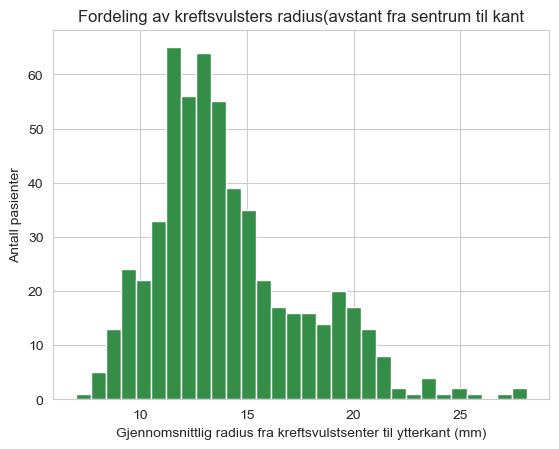

In [52]:
plt.hist(df_kreft_ren["radius_mean"], bins = 30)
plt.xlabel("Gjennomsnittlig radius fra kreftsvulstsenter til ytterkant (mm)")
plt.ylabel("Antall pasienter")
plt.title("Fordeling av kreftsvulsters radius(avstant fra sentrum til kant")

#Vis stolpediagram
plt.show()


Fordelingen  viser at de fleste pasientene hadde gjennomsnittlig cellkjernestørrelse i kreftsvulsten mellom 10 og 15 mikrometer (µm). Noen Pasienter hadde en gjennomsnittlig cellkjernestørrelse på over 20 µm.

#### 5.1.2  Distribusjon av   Omkrets

Omkrets ble målt som avstanden rundt cellekjernens kant.

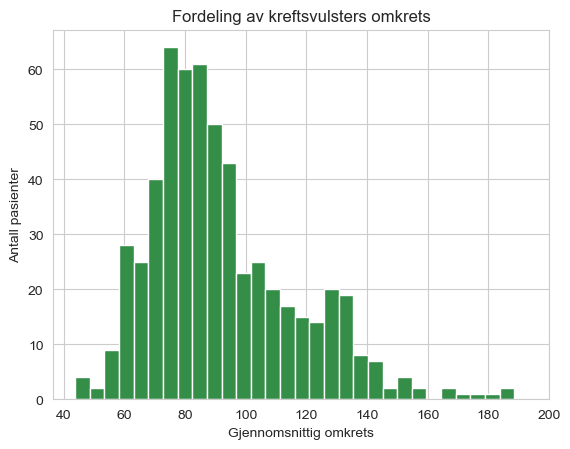

<Figure size 640x480 with 0 Axes>

In [56]:
plt.hist(df_kreft_ren["perimeter_mean"], bins = 30)
plt.xlabel("Gjennomsnittig omkrets")
plt.ylabel("Antall pasienter")
plt.title("Fordeling av kreftsvulsters omkrets")
plt.xticks([40, 60, 80, 100, 120, 140, 160, 180, 200])

#Vis stolpediagram
plt.show()
plt.clf()

Fordelingen av omkrets er svært lik fordelingen av radius. Som i det forrige diagrammet, observeres en venstreskjev fordeling, sannsynligvis forårsaket av pasienter med ekstremt store cellekjerner. Disse pasientene har mest sannsynlig ondartet kreft.

#### 5.1.3  Distribusjon av   Areal


Areal ble målt ved å telle antall piksler innenfor cellekjernens grense og legge til halvparten av pikslene på omkretsen.

Text(0.5, 1.0, 'Fordeling av cellekjerneareal i kreftsvulster')

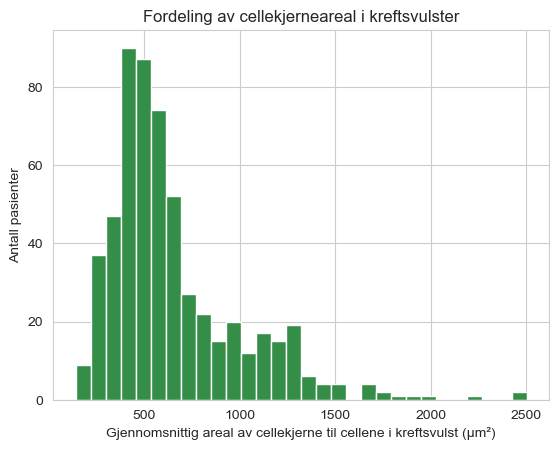

In [60]:
plt.hist(df_kreft_ren["area_mean"], bins = 30)
plt.xlabel("Gjennomsnittig areal av cellekjerne til cellene i kreftsvulst (µm²)")
plt.ylabel("Antall pasienter")
plt.title("Fordeling av cellekjerneareal i kreftsvulster")

Fordelingen av cellekjernareal er tilnærmet lik fordelingen av de to andre størrelsevariablene. Videre analyse vil undersøke styrken av assosiasjonen mellom disse variablene, samt assosiasjonen mellom disse og kreftsvulsttype. Før dette vil jeg imidlertid undersøke fordelingen av overflate- og teksturegenskaper.

## 5.2 Fordeling av Overflateegenskaper

I denne delen skal jeg visualisere overflattegenskapeene til cellkjerner i kreftsvulstene.Dette inkluderer glatthet, konkavitet, og  konkave punkter

 Stil og farge for diagramer over overflateegenskaper justeres

In [65]:
sns.set_style("darkgrid")
sns.set_palette("RdBu")

#### 5.2.1 Fordeling av glatthet

Glatthet ble kvantifisert ved å måle forskjellen mellom lengden på hver radius og gjennomsnittslengden til de omkringliggende radiene.

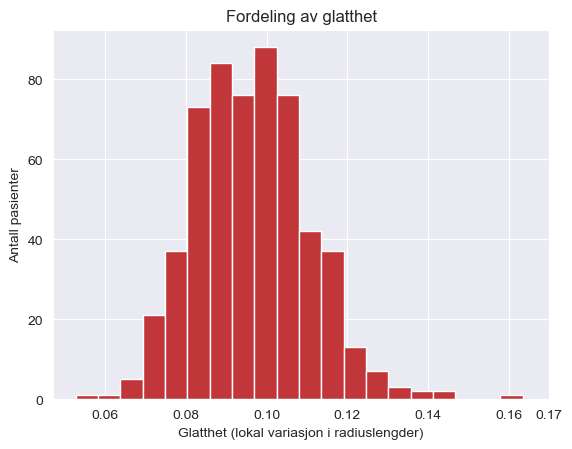

<Figure size 640x480 with 0 Axes>

In [68]:
plt.hist(df_kreft_ren["smoothness_mean"], bins = 20)
plt.xlabel("Glatthet (lokal variasjon i radiuslengder)")
plt.ylabel("Antall pasienter")
plt.title("Fordeling av glatthet")
plt.xticks([0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.17])

#Vis stolpediagram
plt.show()
plt.clf()

#### 5.2.2 Fordeling av konkavitet

Konkavitet ble bestemt ved å måle størrelsen på eventuelle innbuktninger i cellekjernens ytterkant.

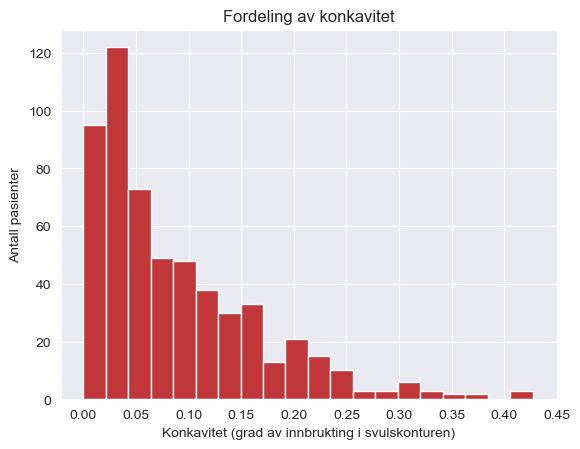

<Figure size 640x480 with 0 Axes>

In [71]:
plt.hist(df_kreft_ren["concavity_mean"],bins = 20)
plt.xlabel("Konkavitet (grad av innbrukting i svulskonturen)")
plt.ylabel("Antall pasienter")
plt.title("Fordeling av konkavitet")
plt.xticks([0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45])

#Vis stolpediagram
plt.show()
plt.clf()

Stolpediagrammet for konkavitet viser verdier fra 0 til 0.45. Vi ser at de fleste av cellekjernene hadde en konkavitet mellom 0 og 0.1, noe som indikerer at overflaten til kreftsvulstenes cellekjerner generelt var ganske regelmessig. Imidlertid ser vi også en del prøver med en høyere grad av innbuktning noe som kan være assosiert med ondartert type kreftseller.

#### 5.2.3 Fordeling av Konkave punkter

Konkave punkter telte antall punkter på cellekjernens ytterkant som ligger i en innbuktning.

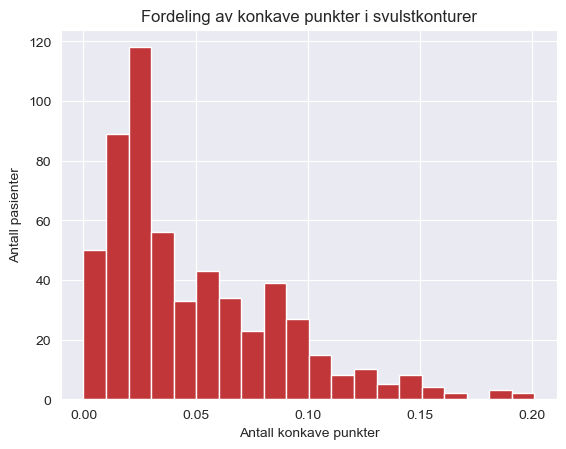

<Figure size 640x480 with 0 Axes>

In [75]:
plt.hist(df_kreft_ren["concave points_mean"],bins = 20)
plt.xlabel("Antall konkave punkter")
plt.ylabel("Antall pasienter")
plt.title("Fordeling av konkave punkter i svulstkonturer")
plt.xticks([0.00, 0.050, 0.100, 0.1500, 0.200])

#Vis stolpediagram
plt.show()
plt.clf()

## 5.3 Teksturegenskaper

Tekstur egenskaper er følgene: tekstur, symmetri, kompakthetsindeks, og fraktal dimensjon
Justerer stil og farge til teksturegenskaper

Stil til teksturegenskaper justeres:

sns.set_style("white")

#### 5.3.1 Tekstur

Tekstur ble målt ved å finne variansen i gråtoneintensitetene i de enkelte pikslene.

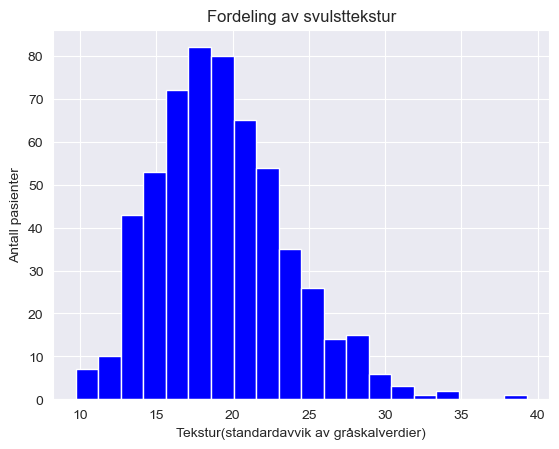

<Figure size 640x480 with 0 Axes>

In [82]:
plt.hist(df_kreft_ren["texture_mean"], bins = 20, color = "blue")
plt.xlabel("Tekstur(standardavvik av gråskalverdier)")
plt.ylabel("Antall pasienter")
plt.title("Fordeling av svulsttekstur")

#Vis stolpediagram
plt.show()
plt.clf()

#### 5.3.2 Symmetri

Symmetri ble målt ved å finne den relative forskjell i lengde mellom linjesegmenter som var vinkelrett på og på hver side av hovedaksen.

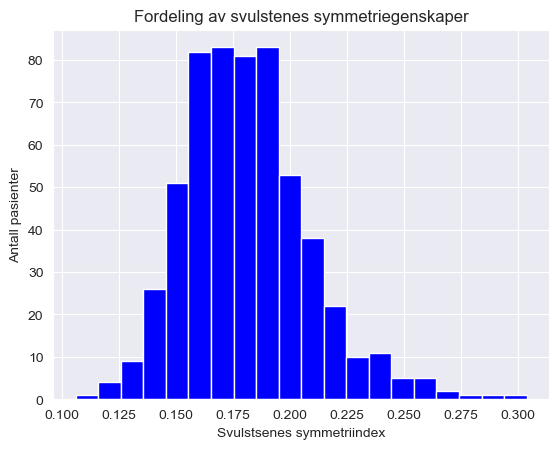

<Figure size 640x480 with 0 Axes>

In [85]:
#Fordeling av symmetri
plt.hist(df_kreft_ren["symmetry_mean"],bins = 20, color = "blue" )
plt.xlabel("Svulstsenes symmetriindex")
plt.ylabel("Antall pasienter")
plt.title("Fordeling av svulstenes symmetriegenskaper")

#Vis stolpediagram
plt.show()
plt.clf()

#### 5.3.3 Kompakthet

Omkrets og areal ble kombinert for å gi et mål på kompaktheten til cellekjernene ved hjelp av følgende formel: omkrets²/areal.

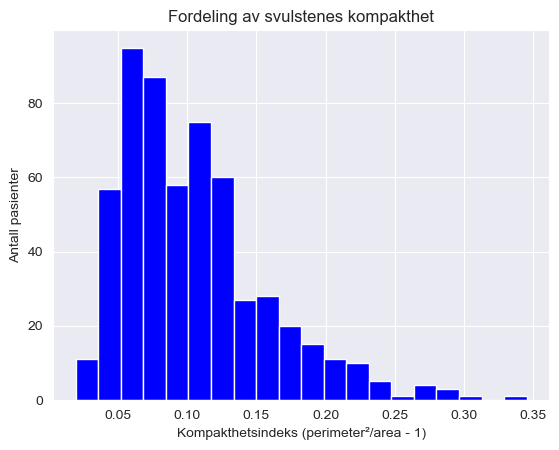

<Figure size 640x480 with 0 Axes>

In [88]:

plt.hist(df_kreft_ren["compactness_mean"],bins = 20, color = "blue")
plt.xlabel("Kompakthetsindeks (perimeter²/area - 1)")
plt.ylabel("Antall pasienter")
plt.title("Fordeling av svulstenes kompakthet")

#Vis stolpediagram
plt.show()
plt.clf()



#### 5.3.4 Fraktal dimensjon

Fraktal dimensjon ble tilnærmet ved hjelp av "kystlinjeapproksimasjonen" som målte uregelmessigheten i cellekjernens ytterkant.

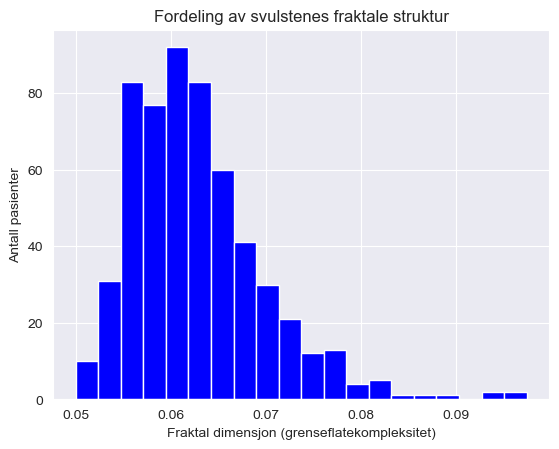

<Figure size 640x480 with 0 Axes>

In [91]:
#Fordeling av Fraktal dimensjon
plt.hist(df_kreft_ren["fractal_dimension_mean"],bins = 20, color = "blue")
plt.xlabel("Fraktal dimensjon (grenseflatekompleksitet)")
plt.ylabel("Antall pasienter")
plt.title("Fordeling av svulstenes fraktale struktur")

#Vis stolpediagram
plt.show()
plt.clf()

## 5.4 Visualisering og analyse av kreftsvulststørrelse
I forrige del visualiserte jeg tre hovedkategorier av variabler: størrelse (omkrets, radius og areal), overflateegenskaper (glatthet, konkavitet, konkave punkter) og teksturegenskaper (tekstur, symmetri, kompakthetsindeks og fraktal dimensjon).

I denne delen skal jeg visualisere IQR-uteliggere og undersøke størrelsesvariablene (areal, omkrets og radius) nærmere, med fokus på deres fordeling, kvartiler, ekstremverdier, gjennomsnitt og konfidensintervaller (KI).

I tillegg skal jeg visualisere konfidensintervaller og gjennomsnittlige verdier for variablene ved hjelp av søylediagrammer.


In [93]:
sns.set_context("notebook")
sns.set_style("whitegrid")
sns.set_palette("PRGn_r")
#Definisjon av etiker for krefttyper
xtick_labels_type_kreft = ["Godartet", "Ondartet"]

#### 5.4.1 Vurdering og visualisering av uteliggere i cellekjernens radiusforskjeller mellom godartede og ondartede kreftsvulster

Visualisering av radius
Boksplott for radius

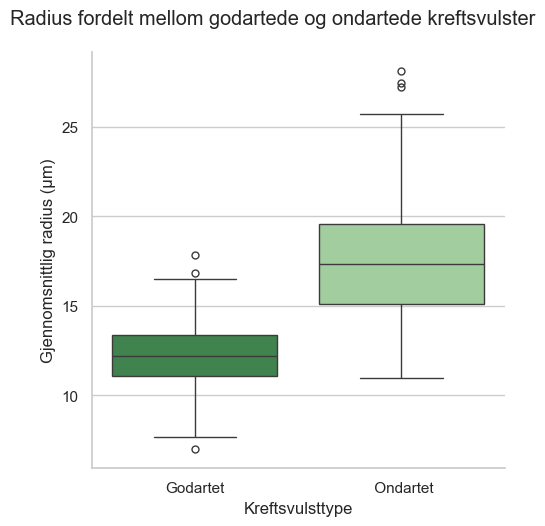

<Figure size 640x480 with 0 Axes>

In [96]:
radius_box = sns.catplot(x = "num_diagnosis", 
                       y = "radius_mean",
                       data = df_kreft_ren, 
                       kind = "box",
                       hue = "num_diagnosis", 
                       legend = False)

#Tilpass radius_box_plot
radius_box.figure.suptitle("Radius fordelt mellom godartede og ondartede kreftsvulster", y = 1.05)
plt.xticks([0, 1], labels = ["Godartet", " Ondartet"])
plt.xlabel("Kreftsvulsttype")
plt.ylabel("Gjennomsnittlig radius (µm)")

#Vis plot
plt.show()
plt.clf()


Søylediagram for radius

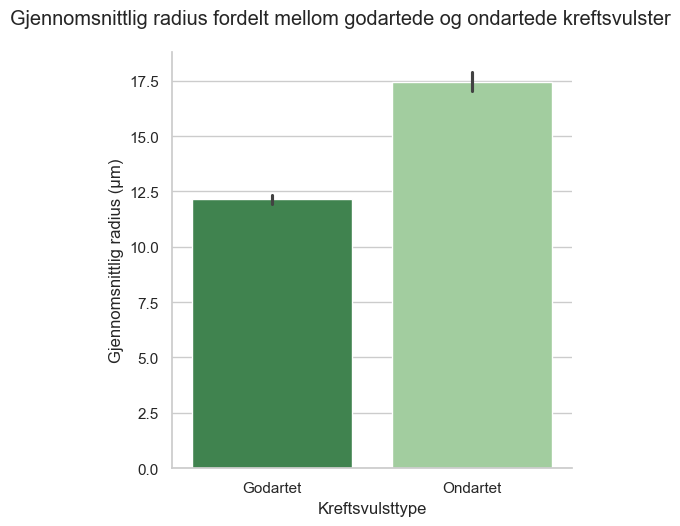

<Figure size 640x480 with 0 Axes>

In [98]:
radius_bar = sns.catplot(x = "num_diagnosis",
                       y = "radius_mean", 
                       data = df_kreft_ren, 
                       kind = "bar",
                       hue = "num_diagnosis", 
                       legend = False)

#Tilpass søylediagram
radius_bar.figure.suptitle("Gjennomsnittlig radius fordelt mellom godartede og ondartede kreftsvulster", y = 1.05)
plt.xticks([0, 1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulsttype")
plt.ylabel("Gjennomsnittlig radius (µm)")

#Vis søylediagram
plt.show()
plt.clf()


Gjennomsnittig og median cellekjerneradius fordelt mellom godartede og ondartede kreftsvulster hvor 0 = Godartet og 1 = Ondartert kreftsvulst


In [100]:
pd.pivot_table(df_kreft_ren,index = "num_diagnosis",values = "radius_mean" , aggfunc = ["mean","median"])

,mean,median
,radius_mean,radius_mean
num_diagnosis,,
0,12.146524,12.200
1,17.462830,17.325


#### 5.4.2 Vurdering og visualisering av uteliggere i cellekjernens omkretsforskjeller mellom godartede og ondartede kreftsvulster

Visualisering omkrets
Boksplott for omkrets

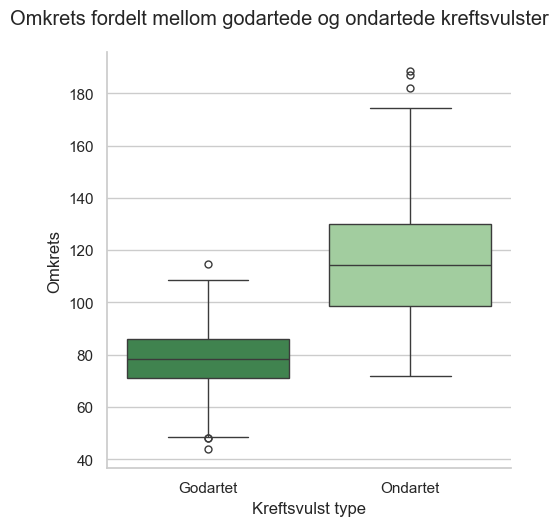

<Figure size 640x480 with 0 Axes>

In [103]:
omkrets_box = sns.catplot(x = "num_diagnosis" ,
                          y = "perimeter_mean", 
                          data = df_kreft_ren, 
                          kind = "box", 
                          hue = "num_diagnosis", 
                          legend = False)

#Tilpass omkrets boksplott
omkrets_box.fig.suptitle("Omkrets fordelt mellom godartede og ondartede kreftsvulster", y = 1.05)
plt.xticks([0,1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Omkrets")

#Vis boksplott
plt.show()
plt.clf()


Som for radiusvariabelen ser vi at medianomkretsen for ondartede kreftsvulster omtrent tilsvarer uteliggerne for godartede svulster. Medianradiusen for godartede og ondartede kreftsvulster ligger ganske langt fra hverandre.

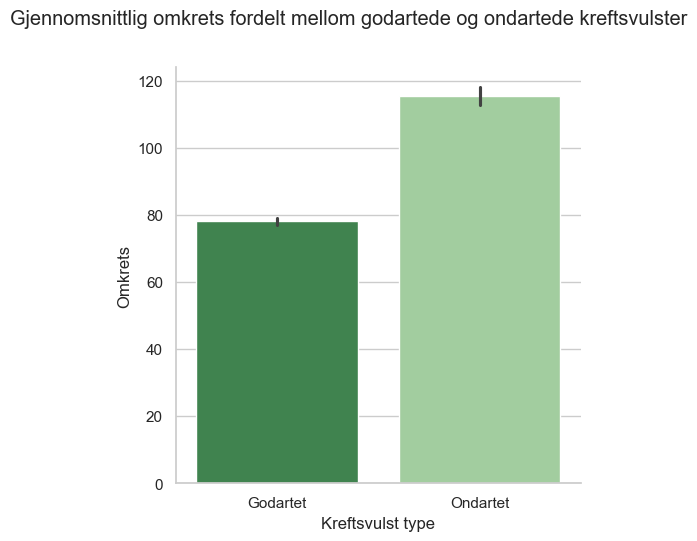

In [105]:
omkrets_catplot = sns.catplot(x = "num_diagnosis",
                             y = "perimeter_mean",
                             data = df_kreft_ren,
                             kind = "bar",
                             hue = "num_diagnosis",
                             legend = False)

#Tilpass søylediagram for omkrets
omkrets_catplot.figure.suptitle("Gjennomsnittlig omkrets fordelt mellom godartede og ondartede kreftsvulster", y = 1.08)
plt.xticks([0, 1], labels = xtick_labels_type_kreft)
plt.ylabel("Omkrets")
plt.xlabel("Kreftsvulst type")

#Vis søylediagram
plt.show()


Gjennomsnittig og median cellekjerneomkrets fordelt mellom godartede og ondartede kreftsvulster hvor 0 = Godartet og 1 = Ondartert kreftsvulst

In [107]:
duckdb.query("""
SELECT AVG(perimeter_mean) AS average_perimeter, 
       MEDIAN(perimeter_mean)  AS median_perimeter
       FROM df_kreft_ren 
       GROUP BY num_diagnosis;""").to_df()

,average_perimeter,median_perimeter
0,78.075406,78.18
1,115.365377,114.20


Søylediagrammet viser at gjennomsnittlig cellekjerneomkrets pleier å være større hos ondartede enn hos godartede kreftsvulster.Søylediagrammet viser at gjennomsnittlig cellekjerneomkrets er omtrent 78µm for godartede og 110 µm for ondartede svulster.

#### 5.4.3 Vurdering og visualisering av uteliggere i cellekjernens areal omkretsforskjeller mellom godartede og ondartede kreftsvulster

 Visualisering av areal
 Boksplott for areal

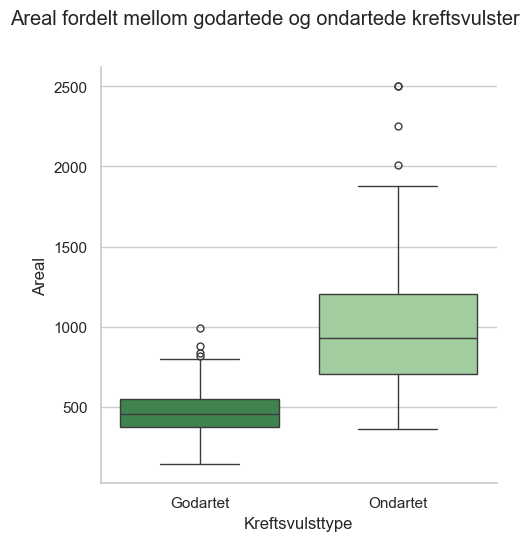

<Figure size 640x480 with 0 Axes>

In [111]:
area_box = sns.catplot(y = "area_mean", 
                       x = "num_diagnosis", 
                       data = df_kreft_ren, 
                       hue = "num_diagnosis", 
                       legend = False, 
                       kind = "box")
# Tilpass boksplott
area_box.fig.suptitle("Areal fordelt mellom godartede og ondartede kreftsvulster", y = 1.08)
plt.xticks(ticks= [0, 1], labels= xtick_labels_type_kreft)
plt.xlabel("Kreftsvulsttype")
plt.ylabel("Areal")

#Vis plott
plt.show()
plt.clf()

Gjennomsnittig og median cellekjernesareal fordelt mellom godartede og ondartede kreftsvulster hvor hvor 0 = Godartet og 1 = Ondartert kreftsvulst

In [113]:
print(df_kreft_ren["area_mean"].groupby(df_kreft_ren["num_diagnosis"]).agg(["mean", "median"]))

                     mean  median
num_diagnosis                    
0              462.790196   458.4
1              978.376415   932.0


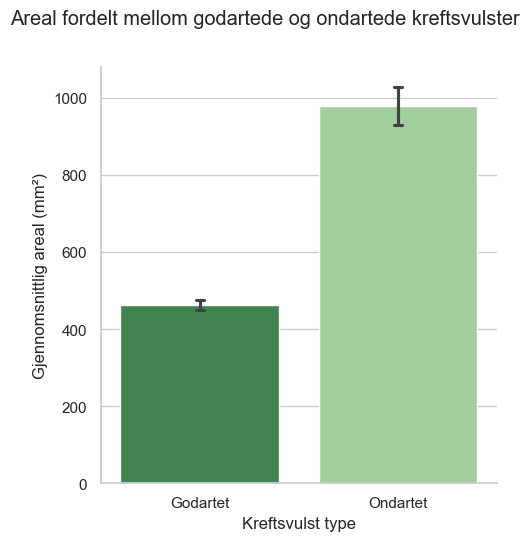

<Figure size 640x480 with 0 Axes>

In [114]:
area_cat = sns.catplot(x = "num_diagnosis", 
                       y = "area_mean",  
                       data = df_kreft_ren, 
                       kind = "bar",
                       hue = "num_diagnosis",
                       legend = False,
                       capsize = 0.04)

#Tilpass søylediagram
area_cat.fig.suptitle("Areal fordelt mellom godartede og ondartede kreftsvulster", y = 1.08)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Gjennomsnittlig areal (mm²)")
plt.xticks(ticks = [0, 1], labels = xtick_labels_type_kreft)

#Vis søylediagram
plt.show()
plt.clf()

Søylediagrammer og boksplotter viste konsistent at ondartede og godartede skilte seg fra hverandre i cellekjernestørrelse. I hvert tilfelle hadde ondartede kreftsvulster en høyere median og gjennomsnittlig areal, omkrets og radius. Videre var det betydelig flere ekstremt store cellekjerner blant ondartede kreftsvulster, og selv de største cellekjernene i godartede svulster var mye mindre sammenlignet med de ondartede. Gjennomsnittet var konsistent høyere enn medianen, hos alle størrelsesvariablene, noe som tilsvarer en høyre-skjev fordeling. Dette forklarer det høyere gjennomsnittet for størrelsesvariablene og tilstedeværelsen av noen ekstremt store cellekjerner blant kreftsvulstene.

## 5.5. Visualisering og analyse av kreftsvulsters overflateegenskaper

I forrige del visualiserte jeg cellekjerners størrelsesvariabler. I denne delen skal jeg fokusere på overflateegenskaper (glatthet, konkavitet og konkave punkter).
I denne delen skal jeg visualisere uteliggere og undersøke overflateegenskapene (glatthet, konkavitet og konkave punkter) nærmere, med fokus på deres fordeling, gjennomsnitt, median, kvartiler og ekstremverdier.
I tillegg skal jeg visualisere konfidensintervaller og gjennomsnittlige verdier for variablene ved hjelp av søylediagrammer.

Justering av stil for overflateegenskaper


In [119]:
sns.set_context("notebook")
sns.set_style("darkgrid")
sns.set_palette("RdBu")


#### 5.5.1 Visualisering av uteliggere, median og kvartiler for cellekjerners glatthet fordelt mellom ondartede og godartede kreftsvulster

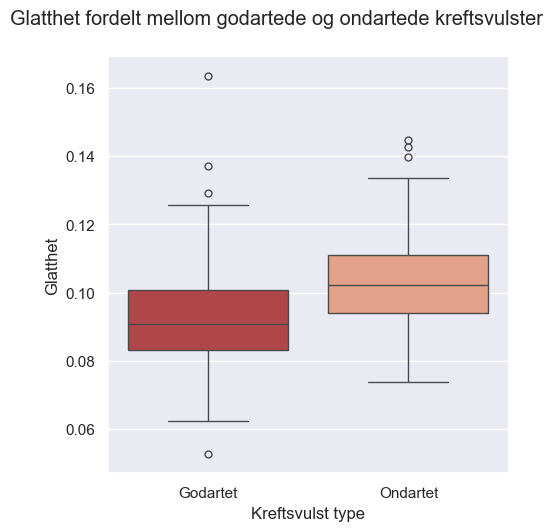

<Figure size 640x480 with 0 Axes>

In [121]:
smoothness_box = sns.catplot(x = "num_diagnosis",
                 y = "smoothness_mean", 
                 data = df_kreft_ren, 
                 hue = "num_diagnosis", 
                 legend = False,
                 kind = "box")

#Tilpass glatthet boksplott
smoothness_box.figure.suptitle("Glatthet fordelt mellom godartede og ondartede kreftsvulster", y = 1.06)
plt.xticks([0,1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Glatthet")

#Vis boksplott
plt.show()
plt.clf()

Gjennomsnittlig og median cellekjerneglatthet fordelt mellom godartede og ondartede kreftsvulster (0 = Godartet, 1 = Ondartet):

In [123]:
duckdb.query("""
SELECT AVG(smoothness_mean) AS average_smoothness, 
       MEDIAN(smoothness_mean)  AS median_smoothness
       FROM df_kreft_ren 
       GROUP BY num_diagnosis;""").to_df()

,average_smoothness,median_smoothness
0,0.092478,0.09076
1,0.102898,0.10220


Boksplottet viser at godartede kreftsvulster generelt har lavere glatthet enn ondartede kreftsvulster. Det er også forskjeller i fordelingen av uteliggere mellom de to gruppene. Ondartede svulster har en tendens til å ha uteliggere konsentrert rundt en verdi på ca. 0.014, mens uteliggere for godartede svulster er mer spredt, med verdier mellom ca. 0.013 og 0.017.

Søylediagram for glatthet

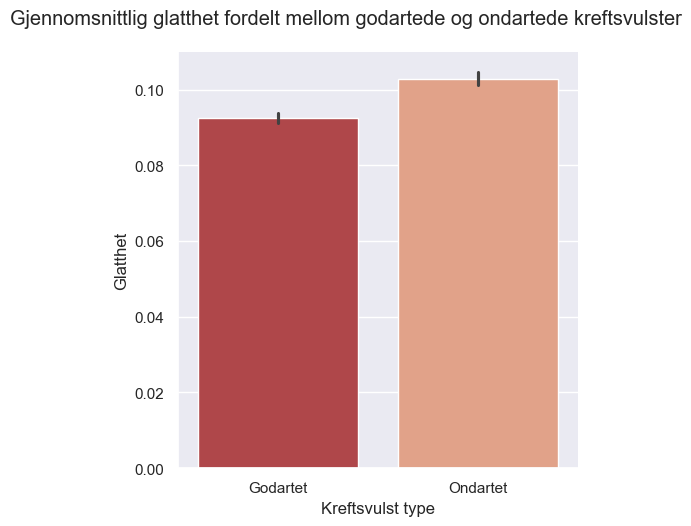

<Figure size 640x480 with 0 Axes>

In [126]:
smoothness_bar = sns.catplot(x = "num_diagnosis",
                 y = "smoothness_mean", 
                 data = df_kreft_ren, 
                 hue = "num_diagnosis", 
                 legend = False,
                 kind = "bar")


#Tiplass glatthet søylediagram
smoothness_bar.figure.suptitle("Gjennomsnittlig glatthet fordelt mellom godartede og ondartede kreftsvulster", y = 1.05)
plt.xticks([0, 1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Glatthet")

#Vis søylediagram
plt.show()
plt.clf()


####5.5.2 Visualisering av uteliggere, median og kvartiler for cellekjerners konkavitet fordelt mellom ondartede og godartede kreftsvulster


Konkavitetsboksplott

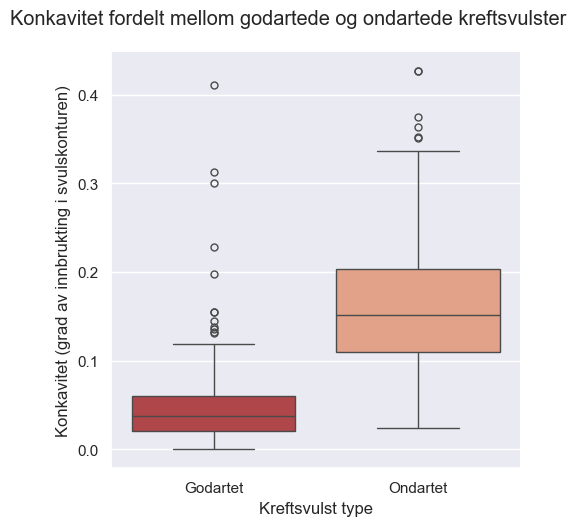

<Figure size 640x480 with 0 Axes>

In [129]:
concavity_box = sns.catplot(x = "num_diagnosis", 
                            y = "concavity_mean", 
                            data = df_kreft_ren, 
                            hue = df_kreft_ren["num_diagnosis"], 
                            legend = False, 
                            kind = "box")

#Tilpass konkavitet boksplott
concavity_box.fig.suptitle("Konkavitet fordelt mellom godartede og ondartede kreftsvulster", y = 1.05)
plt.xticks(ticks = [0,1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Konkavitet (grad av innbrukting i svulskonturen)")

#Vis konkavitet boksplott
plt.show()
plt.clf()

In [130]:
print(df_kreft_ren["concavity_mean"].groupby(df_kreft_ren["num_diagnosis"]).agg(["mean", "median"]))

                   mean   median
num_diagnosis                   
0              0.046058  0.03709
1              0.160775  0.15135


Boksplot og tabell viser at godartede kreftsvulster har en lavere median for gjennomsnittlig konkavitet (0.03) enn ondartede kreftsvulster (0.15). Vi ser flere uteliggere som ligger langt utenfor vanlig IQR. Dette er greit, siden jeg ikke skal bruke denne variabelen som kontinuerlig, men jeg skal omkode den til en dikotom variabel når jeg bruker den til prediksjoner.

Konkavitetsøylediagram

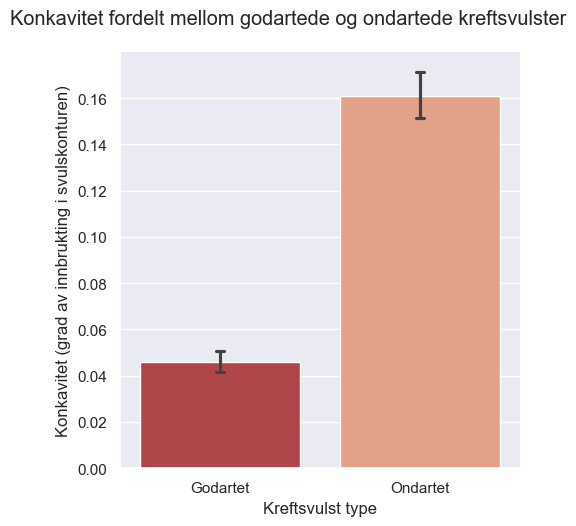

<Figure size 640x480 with 0 Axes>

In [133]:
concavity_bar = sns.catplot(x = "num_diagnosis", 
                            y = "concavity_mean", 
                            data = df_kreft_ren,
                            kind = "bar",
                            hue ="num_diagnosis", 
                            legend = False,
                            capsize = 0.04)

#Tilpass konkavitet søylediagram
concavity_bar.fig.suptitle("Konkavitet fordelt mellom godartede og ondartede kreftsvulster", y = 1.05)
plt.xticks(ticks = [0,1 ],labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Konkavitet (grad av innbrukting i svulskonturen)")

#Vis konkavitet søylediagram
plt.show()
plt.clf()

Gjennomsnittlig konkavitet av cellekjernen er mye lavere blant godartede (0.04) enn blant ondartede (0.16) kreftsvulster.

#### 5.5.3 Visualisering av uteliggere, median og kvartiler for cellekjerners konkavitee punkter fordelt mellom ondartede og godartede kreftsvulster

Visualisering av konkave punkter
Konkave punkter boksplott

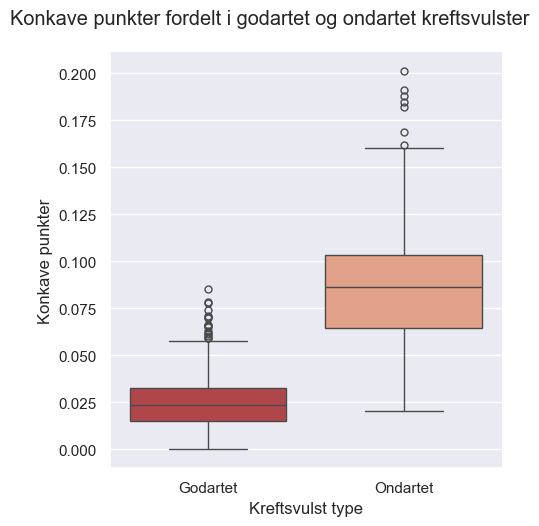

<Figure size 640x480 with 0 Axes>

In [137]:
concave_points_box = sns.catplot(x = "num_diagnosis", 
                            y = "concave points_mean", 
                            data = df_kreft_ren, 
                            hue = "num_diagnosis", 
                            legend = False, 
                            kind = "box")

#Tilpass konkave punkter boksplott
concave_points_box.fig.suptitle("Konkave punkter fordelt i godartet og ondartet kreftsvulster", y = 1.05 )
plt.xticks([0,1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel ("Konkave punkter")

#Vis konkave punkter boksplott
plt.show()
plt.clf()




Boksplottet viser at ondartede kreftsvulster har en betydelig høyere median for konkave punkter (0.08) enn godartede (0.02).  I tillegg ser det ut til at selv de mest ekstreme verdiene for godartede kreftsvulster ligger under medianverdien for ondartede svulster.  La oss undersøke dette nærmere for å bekrefte observasjonen.

In [139]:
print(pd.pivot_table(df_kreft_ren,index = "num_diagnosis",values = "concave points_mean" , aggfunc = ["mean","median"]))
print(df_kreft_ren[df_kreft_ren["num_diagnosis"] == 0]["concave points_mean"].describe())

                             mean              median
              concave points_mean concave points_mean
num_diagnosis                                        
0                        0.025717             0.02344
1                        0.087990             0.08628
count    357.000000
mean       0.025717
std        0.015909
min        0.000000
25%        0.015020
50%        0.023440
75%        0.032510
max        0.085340
Name: concave points_mean, dtype: float64


Resultatene bekrefter at ondartede kreftsvulster har en høyere median og gjennomsnitt for konkave punkter.  Videre analyse av de 357 godartede svulstene viser at den maksimale verdien for konkave punkter (0.201) er lavere enn medianen (0.08) og gjennomsnittet (0.088) for ondartede svulster. Jeg vil utførske dette videre. Jeg skal visualisere og sammenligne ekstreme verdier for konkave punkter blant godartede kreftsvulster, og sammenligne dem med gjennomsnittlig konkave punkter for ondartede kreftsvulster.

#### 5.5.3.1  Utforskning av ekstreme verdier blant godartede og ondartede konkave punkter

In [142]:
#Regning av uteliggere
concave_points_p75 = df_kreft_ren[df_kreft_ren["num_diagnosis"] == 0]["concave points_mean"].quantile(0.75)
concave_points_p25 = df_kreft_ren[df_kreft_ren["num_diagnosis"] == 0]["concave points_mean"].quantile(0.25)
iqr_concave_points = concave_points_p75 - concave_points_p25

# Valg av høye ekstreme verdier
concave_points_upper = concave_points_p75 + (1.5 * iqr_concave_points)

# Validering
print(concave_points_upper)
concave_points_extreme = df_kreft_ren[(df_kreft_ren["concave points_mean"] >= concave_points_upper) & (df_kreft_ren["num_diagnosis"] == 0)]["concave points_mean"]
concave_points_extreme.describe()

0.05874499999999999


count    17.000000
mean      0.067940
std       0.007499
min       0.059330
25%       0.062110
50%       0.066020
75%       0.070640
max       0.085340
Name: concave points_mean, dtype: float64

Visualisering av ekstreme konkave punkter blant godartede kreftsvulster

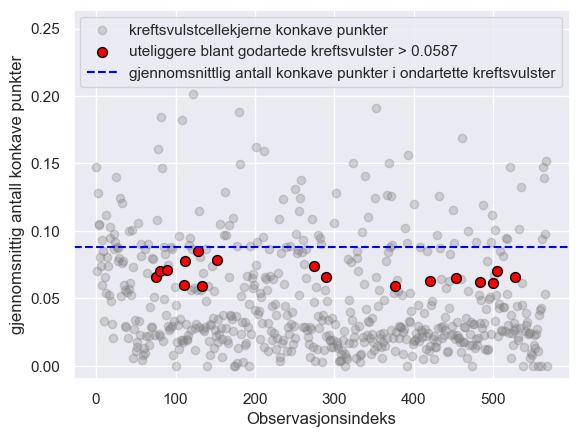

In [144]:
# Alle kreftsvulstcellekjerne konkave punkter i datasettet
plt.scatter(x = df_kreft_ren["concave points_mean"].index, 
            y = df_kreft_ren["concave points_mean"], 
            color = "grey"
            , 
            alpha = 0.3, 
            label = "kreftsvulstcellekjerne konkave punkter")


# Uteliggere blant godartede kreftsvulster som skal vises i rød farge
plt.scatter(x = concave_points_extreme.index, 
            y = concave_points_extreme, 
            color = "red",edgecolor = "black", 
            label = "uteliggere blant godartede kreftsvulster > 0.0587",
            s = 50)

# Tilføying av linje som indikerer gjennomsnittlig cellekjerne konkave punkter i ondartete kreftsvulst
plt.axhline(y = 0.087990 ,
            linestyle = "--", 
            color = "blue", 
            label = "gjennomsnittlig antall konkave punkter i ondartette kreftsvulster")

#Justering utseende av scatter
plt.legend()
current_min, current_max = plt.ylim()
plt.ylim(current_min, current_max * 1.25)
plt.xlabel("Observasjonsindeks")
plt.ylabel("gjennomsnittig antall konkave punkter")
plt.savefig('images/concave_points.png', dpi=300, bbox_inches='tight')
plt.show()


Scatterplotet viser tydelig at alle de observerte godartede kreftsvulstene hadde mindre gjennomsnittig antall konkave punkter enn det gjennomsnittlige antallet konkave punkter konkave punkter som ble observert i de ondartede kreftsvulstene. Denne observasjonen indikerer sannsynligvis sterk korelasjon mellom gjennomsnittig antall konkave punkter i cellekjernen og typen kreftsvulst(godartet eller ondartet).

Konkave pukter søylediagram

Text(3.9444444444444446, 0.5, 'Konkave punkter')

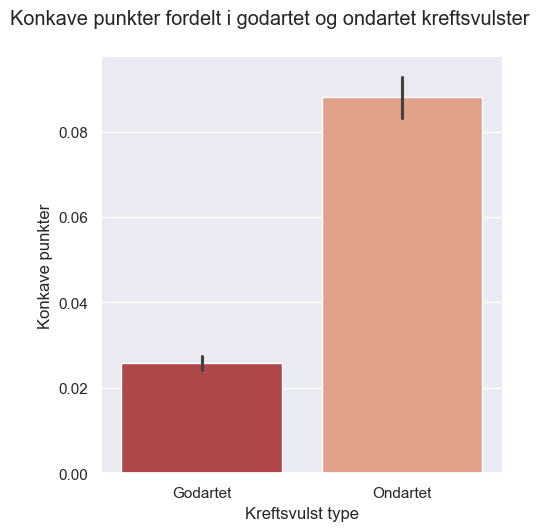

In [147]:
concave_points_bar = sns.catplot(x = "num_diagnosis", 
                                 y = "concave points_mean", 
                                 data = df_kreft_ren, 
                                 hue = "num_diagnosis",
                                 legend = False,
                                 kind = "bar")

#Tilpass #konkave pukter søylediagram
concave_points_bar.figure.suptitle("Konkave punkter fordelt i godartet og ondartet kreftsvulster", y = 1.06)
plt.xticks([0,1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Konkave punkter")

Søylediagrammet viser en stor forskjell i gjennomsnittlig antall konkave punkter mellom godartede (0.025) og ondartede (0.087) kreftsvulster. Dette bekrefter forrige analyse av uteliggere og kan indikere sterk korelasjon mellom gjennomsnittig antall konkave punkter i cellekjernen og typen kreftsvulst(godartet eller ondartet).

## 5.6 Visualisering og analyse av kreftsvulsters teksturegenskaper


I forrige del visualiserte jeg cellekjerners størrelsesvariabler og overflatteegenskaper. I denne delen skal jeg fokusere på teksturegenskaper (tekstur, symmetri, kompakthetsindeks, og grenseflatekompleksitet).
I denne delen skal jeg visualisere uteliggere og undersøke teksturegenskaper (tekstur, symmetri, kompakthetsindeks, og grenseflatekompleksitet) nærmere, med fokus på deres fordeling, gjennomsnitt, median, kvartiler og ekstremverdier.
I tillegg skal jeg visualisere konfidensintervaller og gjennomsnittlige verdier for variablene ved hjelp av søylediagrammer.

Justering av stil og farge for steksturvariabler

In [152]:
sns.set_style("whitegrid")
sns.set_palette("RdBu_r")

#### 5.6.1 Visualisering av tekstur


Tekstur boksplott

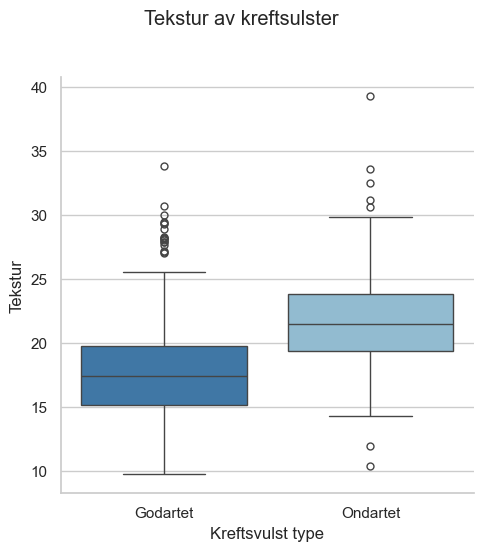

<Figure size 640x480 with 0 Axes>

In [155]:
texture_box = sns.catplot(x = "num_diagnosis",
                 y = "texture_mean", 
                 data = df_kreft_ren, 
                 hue = "num_diagnosis", 
                 legend = False,
                 kind = "box")

#Tilpass tekstur boksplott
texture_box.figure.suptitle("Tekstur av kreftsulster", y = 1.1)
plt.xticks([0,1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Tekstur")

#Vis boksplott
plt.show()
plt.clf()

Boksplottet viser at godartede kreftsvulster har en lavere median i tekstur enn ondartede. Jeg ser også at godartede svulster har mange ekstreme verdier. Jeg skal se litt nærmere på hvor mange det er.

##### 5.6.1.1 Undersøkelse av tekstur- uteliggere

In [158]:
#Regning av uteliggere
texture_p75 = df_kreft_ren[df_kreft_ren["num_diagnosis"] == 0]["texture_mean"].quantile(0.75)
texture_p25 = df_kreft_ren[df_kreft_ren["num_diagnosis"] == 0]["texture_mean"].quantile(0.25)
texture_iqr = texture_p75 - texture_p25
texture_upper = texture_p75  + (1.5 * texture_iqr)
print(texture_upper.round(4))

#Valg av høye ekstreme verdier
texture_outliers = df_kreft_ren.loc[(df_kreft_ren["texture_mean"] > texture_upper) & (df_kreft_ren["num_diagnosis"] == 0)]["texture_mean"]

#Validering
print(len(texture_outliers), texture_upper)
texture_outliers.describe()



26.675
18 26.675000000000004


count    18.000000
mean     28.717222
std       1.629626
min      26.990000
25%      27.857500
50%      28.205000
75%      29.350000
max      33.810000
Name: texture_mean, dtype: float64

Alt stemmer

Visual validasjon av utteliggere

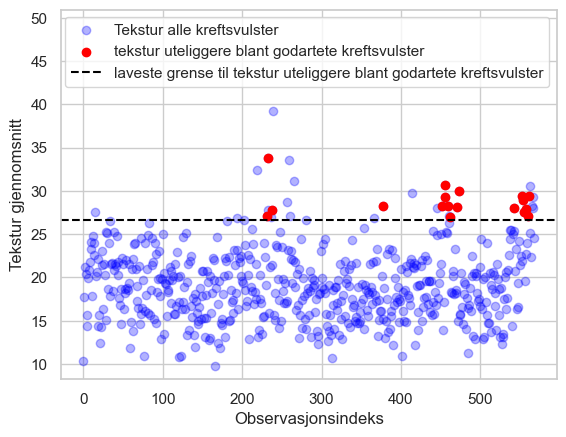

In [161]:
# vusualisering av tekstur
plt.scatter( x = df_kreft_ren.index, 
            y = df_kreft_ren["texture_mean"],
            color = "blue", 
            alpha = 0.3, label = "Tekstur alle kreftsvulster")

#visualisering av uteliggere
plt.scatter(x = texture_outliers.index, 
            y = texture_outliers , 
            color = "red",
           label = "tekstur uteliggere blant godartete kreftsvulster")

#Tilføying av linje som definerer nedre grense for tekstur-uteliggere blant godartede kreftsvulster
plt.axhline(y = texture_upper, 
            color = "black", 
            linestyle = "--",
            label ="laveste grense til tekstur uteliggere blant godartete kreftsvulster")

#Justering av utseende
current_min, current_max = plt.ylim()
plt.ylim(current_min, current_max * 1.25)
plt.xlabel("Observasjonsindeks")
plt.ylabel("Tekstur gjennomsnitt")
plt.legend()

#Vis scatterplott
plt.show()




Scatterplott bekrefter at de fleste av utteliggere(markert rødt) er konsentrert mellom 25 og 30, og det er bare to uteliggere som ligger mellom 30-35, noe som stemmer med uteliggerne som ble visst i boksplottet 

#### 5.6.2 Visualisering av uteliggere, median og kvartiler for cellekjerners symmetri fordelt mellom ondartede og godartede kreftsvulster

 Symmetriboxplot

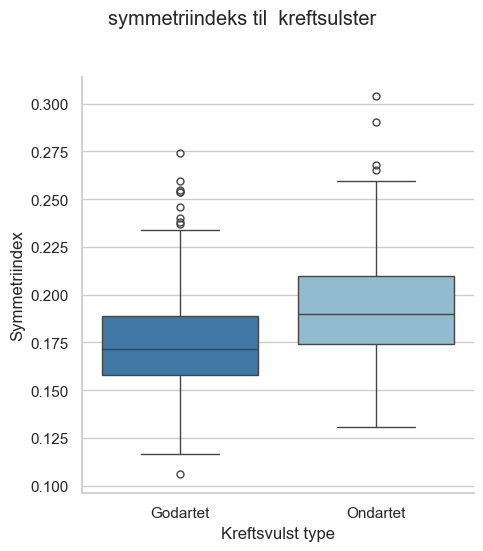

<Figure size 640x480 with 0 Axes>

In [165]:
symmetry_box = sns.catplot(x = "num_diagnosis",
                 y = "symmetry_mean", 
                 data = df_kreft_ren, 
                 hue = "num_diagnosis", 
                 legend = False,
                 kind = "box")

#Tilpass simmetri boksplott
symmetry_box.figure.suptitle("symmetriindeks til  kreftsulster", y = 1.1)
plt.xticks([0,1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Symmetriindex")

#Vis boksplott
plt.show()
plt.clf()

Gjennomsnittlig og median symmetriindeks for cellekjerner fordelt mellom godartede og ondartede kreftsvulster:

In [167]:
duckdb.query("""
SELECT AVG(symmetry_mean) AS average_symmetry, 
       MEDIAN(symmetry_mean)  AS median_symmetry
       FROM df_kreft_ren 
       GROUP BY num_diagnosis;""").to_df()

,average_symmetry,median_symmetry
0,0.174186,0.1714
1,0.192909,0.1899


Boksplottet og tabellen viser at det ondartede kreftsvulster(0.19) har en tendens til å ha høyere median symmetriindeks enn godartede kreftsvulster (0.17).

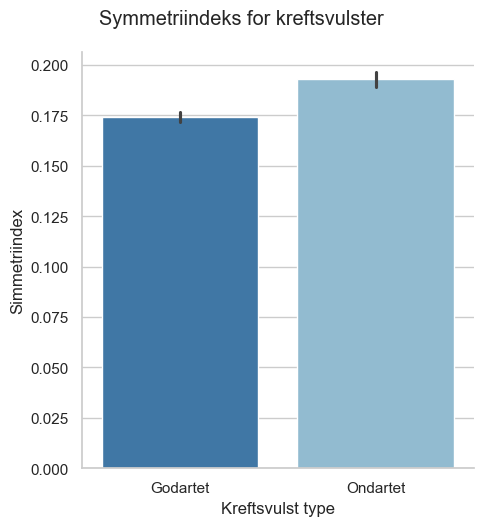

<Figure size 640x480 with 0 Axes>

In [169]:
#Symmetri søylediagram
symmetry_bar = sns.catplot(x = "num_diagnosis",
                 y = "symmetry_mean", 
                 data = df_kreft_ren, 
                 hue = "num_diagnosis", 
                 legend = False,
                 kind = "bar")


#Tiplass symmetri søylediagram
symmetry_bar.figure.suptitle("Symmetriindeks for kreftsvulster", y = 1.05)
plt.xticks([0, 1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Simmetriindex")

#Vis søylediagram
plt.show()
plt.clf()


Konfidens intervallene i søylediagrammet indikerer at det er en forskjell i gjennomsnittlig symmetriindeks mellom godartede(gjennomsnitt på ca. 0.17) og ondartede(gjennomsnitt på ca.0.19) kreftsvulster.

5.6.3 Visualisering av uteliggere, median og kvartiler for cellekjerners kompakthet fordelt mellom ondartede og godartede kreftsvulster

Kompakthet boksplott

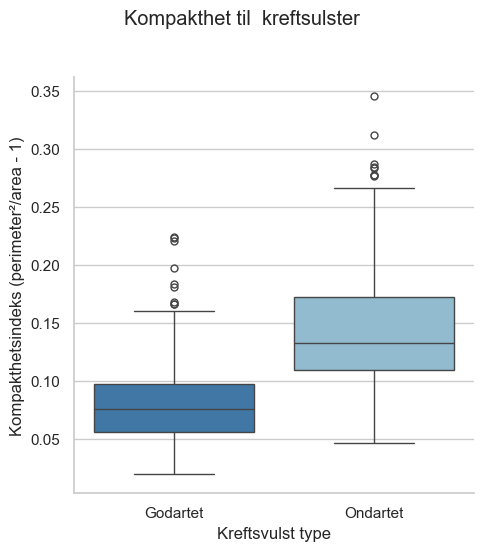

<Figure size 640x480 with 0 Axes>

In [173]:
compactness_box = sns.catplot(x = "num_diagnosis",
                 y = "compactness_mean", 
                 data = df_kreft_ren, 
                 hue = "num_diagnosis", 
                 legend = False,
                 kind = "box")

#Tilpass kompakthet boksplott
compactness_box.figure.suptitle("Kompakthet til  kreftsulster", y = 1.1)
plt.xticks([0,1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Kompakthetsindeks (perimeter²/area - 1)")

#Vis kompakthet boksplott
plt.show()
plt.clf()

Gjennomsnittlig og median symmetriindeks for cellekjerner fordelt mellom godartede og ondartede kreftsvulster:

In [175]:
print(df_kreft_ren["compactness_mean"].groupby(df_kreft_ren["num_diagnosis"]).agg(["mean", "median"]))

                   mean   median
num_diagnosis                   
0              0.080085  0.07529
1              0.145188  0.13235


Boksplottet og tabellen viser at ondartede kreftsvulster(0.13) har en tendens til å ha høyere median  kompakthet enn godartede kreftsvulster (0.07). Ondartede og godartede kreftsvulster er også  forskjellige i ekstreme verdier av kompaktheten. For eksempel har godartede kreftsvulster mye lavere ekstreme verdier i kompakthet enn ondartede kreftsvulster.

Kompakthet søylediagram

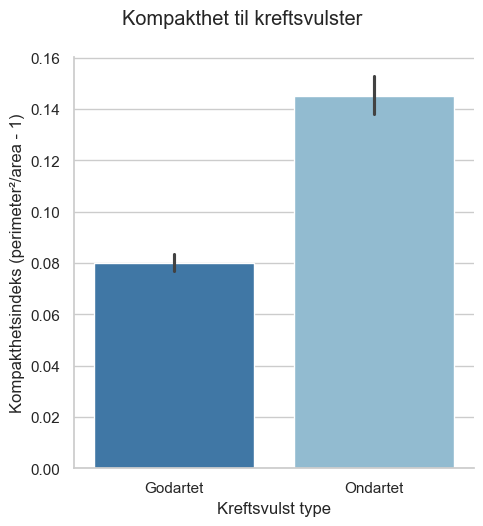

<Figure size 640x480 with 0 Axes>

In [178]:
compactness_bar = sns.catplot(x = "num_diagnosis",
                 y = "compactness_mean", 
                 data = df_kreft_ren, 
                 hue = "num_diagnosis", 
                 legend = False,
                 kind = "bar")


#Tiplass kompakthet søylediagram
compactness_bar.figure.suptitle("Kompakthet til kreftsvulster", y = 1.05)
plt.xticks([0, 1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Kompakthetsindeks (perimeter²/area - 1)")

#Vis søylediagram
plt.show()
plt.clf()


Konfidens intervallene i søylediagrammet indikerer at det er en forskjell i gjennomsnittlig kompakthetsindeks mellom godartede(gjennomsnitt på ca. 0.8) og ondartede(gjennomsnitt på ca.0.15) kreftsvulster

5.6.4 Visualisering av uteliggere, median og kvartiler for cellekjerners fraktal dimensjon fordelt mellom ondartede og godartede kreftsvulster

Fraktal dimensjon boksplott

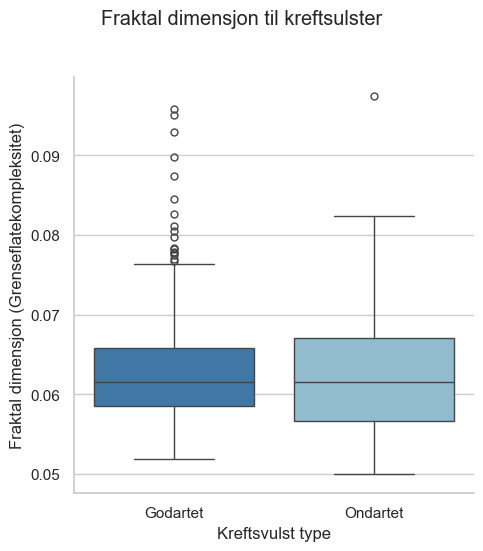

<Figure size 640x480 with 0 Axes>

In [182]:
fractal_box = sns.catplot(x = "num_diagnosis",
                 y = "fractal_dimension_mean", 
                 data = df_kreft_ren, 
                 hue = "num_diagnosis", 
                 legend = False,
                 kind = "box")

#Tilpass fraktal dimensjon boksplott
fractal_box.figure.suptitle("Fraktal dimensjon til kreftsulster", y = 1.1)
plt.xticks([0,1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Fraktal dimensjon (Grenseflatekompleksitet)")

#Vis grenseflatekompleksitet boksplott
plt.show()
plt.clf()





Gjennomsnittlig og median fraktal dimensjon for cellekjerner fordelt mellom godartede og ondartede kreftsvulster:

In [184]:
print(pd.pivot_table(df_kreft_ren,index = "num_diagnosis",values = "fractal_dimension_mean" , aggfunc = ["mean","median"]))
print(df_kreft_ren[df_kreft_ren["num_diagnosis"] == 0]["fractal_dimension_mean"].describe())

                                mean                 median
              fractal_dimension_mean fractal_dimension_mean
num_diagnosis                                              
0                           0.062867               0.061540
1                           0.062680               0.061575
count    357.000000
mean       0.062867
std        0.006747
min        0.051850
25%        0.058530
50%        0.061540
75%        0.065760
max        0.095750
Name: fractal_dimension_mean, dtype: float64


Boksplottet viser betydelig variasjon i ekstreme verdier blant godartede kreftsvulster. Jeg forventer en svært lav korrelasjon mellom kreftsvulsttype og fraktal dimensjon. Medianen for fraktal dimensjon er omtrent 0.061 for både ondartede og godartede kreftsvulster.

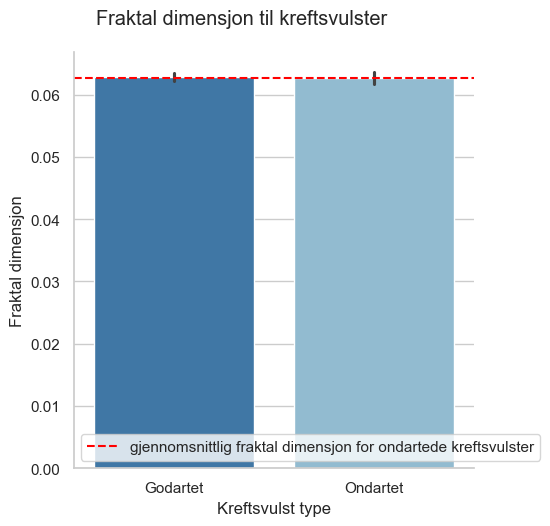

<Figure size 640x480 with 0 Axes>

In [186]:
# Fraktal dimensjon søylediagram
fractal_bar = sns.catplot(x = "num_diagnosis",
                 y = "fractal_dimension_mean", 
                 data = df_kreft_ren, 
                 hue = "num_diagnosis", 
                 legend = False,
                 kind = "bar")


# Tilpass fraktal dimensjon søylediagram
fractal_bar.figure.suptitle("Fraktal dimensjon til kreftsvulster", y = 1.05,)
plt.xticks([0, 1], labels = xtick_labels_type_kreft)
plt.xlabel("Kreftsvulst type")
plt.ylabel("Fraktal dimensjon")
plt.axhline(y = 0.062680, linestyle = "--", color = "red", label = "gjennomsnittlig fraktal dimensjon for ondartede kreftsvulster")
plt.legend()

#Vis søylediagram

plt.show()
plt.clf()


EDA viste at det er flere variabler, for eksempel størrelsesvariabler, som har en svært høy korrelasjon med kreftsvulsttype, mens noen variabler, for eksempel fraktal dimensjon, ikke har mye å si når det gjelder kreftsvulsttype. Jeg skal se nærmere på multikollinearitet, og jeg skal utføre en hypotesetest for å bekrefte lineær korrelasjon.Søylediagrammet viser at det ikke er noen signifikant forskjell i gjennomsnittig fraktal dimensjon  godartede og ondartede kreftsvulster.

# 6 Varmekart

Jeg undersøke multikollinearitet slik at vi kan forberede datasettet til maskinlæringstrening og utvikle en logistisk modell.

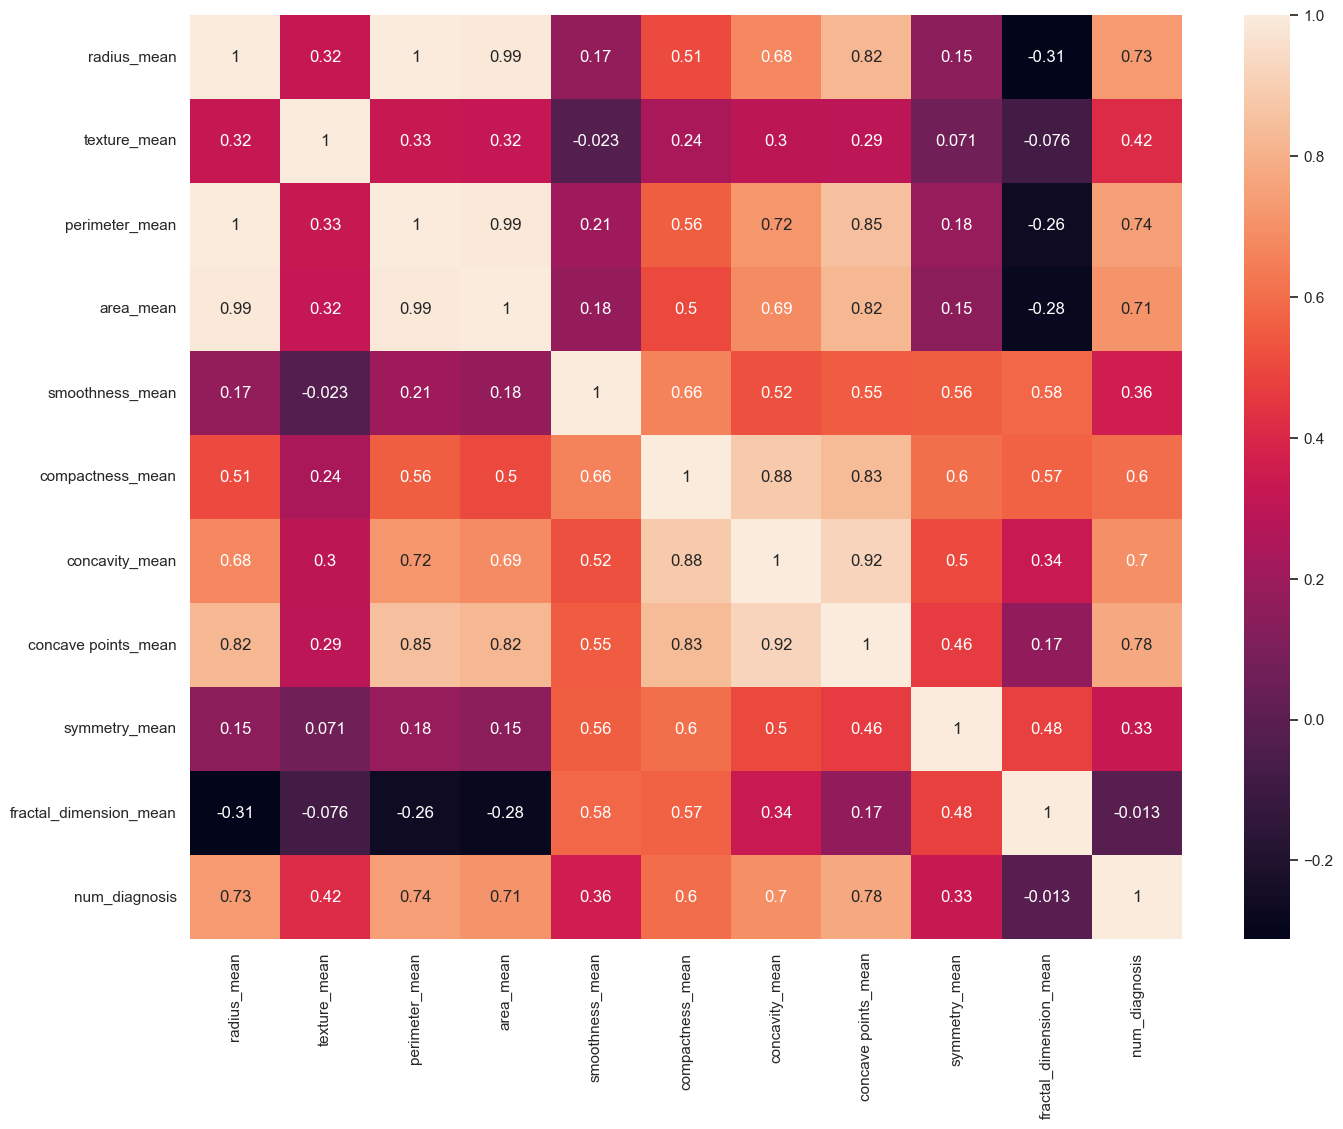

In [190]:
plt.figure(figsize=(16, 12))
sns.heatmap(df_kreft_ren.corr(), annot = True)
plt.savefig('images/varmekart.png', dpi=300, bbox_inches='tight')
plt.show()

Varmekartet viser at størrelsesvariablene radius, tekstur og perimeter har perfekt eller nesten perfekt korrelasjon, og jeg trenger enten å slå dem sammen og bruke dem som én prediktorvariabel, eller bare droppe dem. Konkave punkter har også en svært sterk korrelasjon med nesten alle de utvalgte variablene i datasettet. Jeg skal slå dem sammen med glatthet og konkavitet. Til slutt skal jeg slå sammen variablene tekstur, symmetri og kompakthetsindeks, og kalle blandingen teksturegenskaper. Fraktal dimensjon blir fjernet fra analysen siden den har svært liten korrelasjon med krefttypen.

Før jeg begynner med sammenslåingen av variabler, må jeg dele datasettet i et treningsdatasett og et testdatasett. Treningsdatasettet vil bestå av 70 % av dataene, og testdatasettet vil bestå av 30 % av dataene.

# 7 Omkoding og forberedelse av datasettet til prediksjonsmodell.

#### 7.1 Segmenter datasettet i uavhengige variabler (X)

In [195]:
# Skriver ut navnene på kolonnene
print(df_kreft_ren.columns)
# Segmenter datasettet i uavhengige variabler (X)
df_kreft_ren_x = df_kreft_ren.loc[:, "radius_mean" : "symmetry_mean" ].copy()
df_kreft_ren_x.drop(["perimeter_mean", 'area_mean'], axis = 1)
#Validering
print(df_kreft_ren_x.columns)
print(df_kreft_ren_x.shape)
print(df_kreft_ren_x.head())

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'num_diagnosis'],
      dtype='object')
Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean'],
      dtype='object')
(569, 9)
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  
0   

#### 7.2 Segment dataset i uavhengig variabel y vatiables(Y)

In [197]:
df_kreft_ren_y = df_kreft_ren[['num_diagnosis']]

#Validering
type(df_kreft_ren_y)
print(df_kreft_ren_y.shape, df_kreft_ren_y.value_counts())
print(df_kreft_ren_y.head(10))

(569, 1) num_diagnosis
0                357
1                212
Name: count, dtype: int64
   num_diagnosis
0              1
1              1
2              1
3              1
4              1
5              1
6              1
7              1
8              1
9              1


Alt stemmer

#### 7.3 Del datasettet i trenings- og testsett for features og targets

In [200]:
#Del dataset i trening og testing features and targets
df_kreft_ren_x_train, df_kreft_ren_x_test, df_kreft_ren_y_train, df_kreft_ren_y_test = train_test_split(df_kreft_ren_x, df_kreft_ren_y, train_size = 0.7, test_size = 0.3, random_state=42)
#Validering
print(df_kreft_ren_x_train.shape)
print(df_kreft_ren_y_train.shape)
print(df_kreft_ren_x_test.shape)
print(df_kreft_ren_y_test.shape)

(398, 9)
(398, 1)
(171, 9)
(171, 1)


#### 7.4. Omkoding av størrelsevariabler


I regresjonen skal jeg kun beholde radiusvariabelen. Grunnen til det er nesten perfekt korrelasjonen (0.99+) mellom radius, areal og omkrets. I tillegg har disse tre ganske høy korrelasjon med variabelen for konkave punkter Utvalget av radius representerer det beste kompromisset mellom korrelasjonen med utfallsvariabelen (0.73) og kollineariteten med konkave punkter (0.82).

#### 7.4.1 Estimering av diagnostisk terskel for Radius 


Bruk av ROC og AUC for å undersøke radius diagnostisk grenseverdi for ondartede og godartede kreftsvulster.

Optimum grense for radius er 14.19


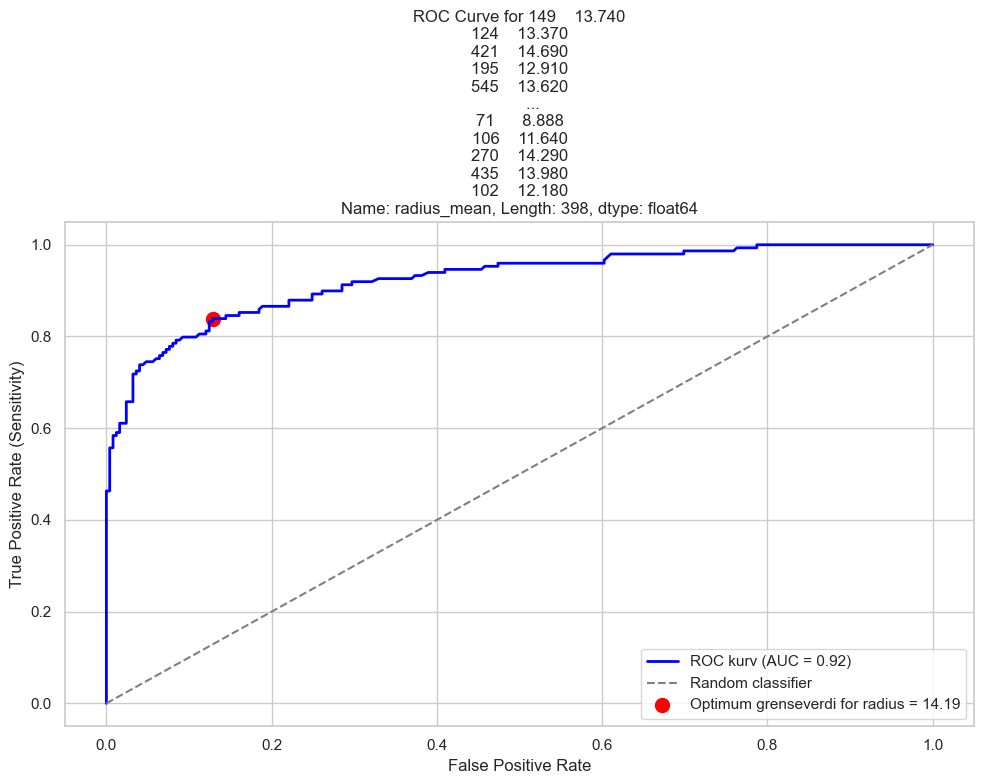

In [205]:

#Tilordne feature- og target-kolonner

#Regning av ROC-kurv og AUC
fpr,tpr,thresholds = roc_curve(df_kreft_ren_y_train["num_diagnosis"], df_kreft_ren_x_train["radius_mean"])
roc_auc = auc(fpr,tpr)

#Optimum grenseverdi
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_benchmark_radius = thresholds[optimal_idx]
print("Optimum grense for radius er", optimal_benchmark_radius)

#ROC kurv
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC kurv (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random classifier')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red',s = 100, label=f'Optimum grenseverdi for radius = {optimal_benchmark_radius:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title(f'ROC Curve for {df_kreft_ren_x_train["radius_mean"]}')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


 AUC = 94 som betyr at hvis vi setter binar grense på 14.25, skal algorytmen forutsi 94 % av kreftsvulster riktig.
 df_kreft_ren_x_train["radius_mean"]
 


#### 7.4.2 Omkoding av radius

In [208]:
df_kreft_ren_x_train["radius_regression"] = df_kreft_ren_x_train["radius_mean"] > optimal_benchmark_radius
#Validering
print(df_kreft_ren_x_train[["radius_regression", "radius_mean"]].head())
df_kreft_ren_x_train["radius_regression"].describe()

     radius_regression  radius_mean
149              False        13.74
124              False        13.37
421               True        14.69
195              False        12.91
545              False        13.62


count       398
unique        2
top       False
freq        242
Name: radius_regression, dtype: object

Omkoding vellykket

## 7.5 Omkoding av overflateegenskaper

#### 7.5.1 Estimering av diagnostisk terskel for Radius 

 Bruk av ROC og AUC for å undersøke diagnostisk grenseverdi for ondartede og godartede kreftsvulster. til alle variablene i overflateegenskaper

Optimum grense for glatthet er 0.09714
Optimum grense for konkavitet er 0.07293
Optimum grense for konkave punkter er 0.05182


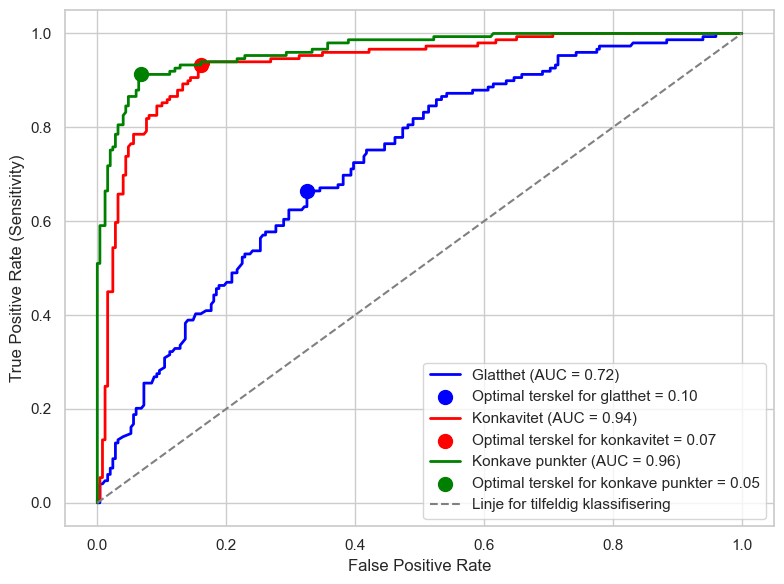

In [213]:
#Beregning av ROC-kurve og AUC for glatthet
fpr1,tpr1,thresholds1 = roc_curve(df_kreft_ren_y_train["num_diagnosis"], df_kreft_ren_x_train["smoothness_mean"])
roc_auc1 = auc(fpr1, tpr1)

#Beregning av ROC-kurve og AUC for konkavitet
fpr2,tpr2,thresholds2 =  roc_curve(df_kreft_ren_y_train["num_diagnosis"], df_kreft_ren_x_train["concavity_mean"])
roc_auc2 = auc(fpr2, tpr2)

#Regning av ROC-kurve og AUC for konkave punkter
fpr3,tpr3,thresholds3 = roc_curve(df_kreft_ren_y_train["num_diagnosis"], df_kreft_ren_x_train["concave points_mean"])
roc_auc3 = auc(fpr3, tpr3)


#Optimum grenseverdier
#kalkulerer j-scores for hver av variabler
j_scores1 = tpr1 - fpr1
j_scores2 = tpr2 - fpr2
j_scores3 = tpr3 - fpr3
#Finner indeksen til den optimale J-scoren for hver variabel
optimal_idx1 = np.argmax(j_scores1)
optimal_idx2 = np.argmax(j_scores2)
optimal_idx3 = np.argmax(j_scores3)

#Optimale terskelverdier for  variabler
optimal_benchmark_smoothness = thresholds1[optimal_idx1]
optimal_benchmark_concavity = thresholds2[optimal_idx2]
optimal_benchmark_concave_points = thresholds3[optimal_idx3]
print("Optimum grense for glatthet er", optimal_benchmark_smoothness)
print("Optimum grense for konkavitet er", optimal_benchmark_concavity)
print("Optimum grense for konkave punkter er", optimal_benchmark_concave_points)

#ROC curve
plt.figure(figsize=(8, 6))
#ROC og optimal terskel for glatthet 
plt.plot(fpr1, tpr1, color='blue', lw=2, label=f'Glatthet (AUC = {roc_auc1:.2f})')
plt.scatter(fpr1[optimal_idx1], tpr1[optimal_idx1], color='blue',s = 100, label=f'Optimal terskel for glatthet = {optimal_benchmark_smoothness:.2f}')
#ROC og optimal terskel konkavitet
plt.plot(fpr2, tpr2, color='red', lw=2, label=f'Konkavitet (AUC = {roc_auc2:.2f})')
plt.scatter(fpr2[optimal_idx2], tpr2[optimal_idx2], color="red",s = 100, label=f'Optimal terskel for konkavitet = {optimal_benchmark_concavity:.2f}')
#ROC og optimal terskel konkave punkter
plt.plot(fpr3, tpr3, color='green', lw=2, label=f'Konkave punkter (AUC = {roc_auc3:.2f})')
plt.scatter(fpr3[optimal_idx3], tpr3[optimal_idx3], color='green', s = 100, label=f'Optimal terskel for konkave punkter = {optimal_benchmark_concave_points:.2f}')

#Linje for tilfeldig klassifisering
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Linje for tilfeldig klassifisering')

#Klargjøring av plott

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Ved bruk av ROC AUC fant vi grenser som vi vil bruke i omkodingen av disse variablene.
Glatthet: Grense ved 0.10 (estimert treffsikkerhet: 72%).
Konkavitet: Grense ved 0.07 (estimert treffsikkerhet: 94%).
Konkave punkter: Grense ved 0.05 (estimert treffsikkerhet: 96%).

#### 7.5.2 Omkoding av glatthet


In [216]:
df_kreft_ren_x_train["smoothness_regression"] = df_kreft_ren_x_train["smoothness_mean"] > optimal_benchmark_smoothness

#Validering
print(df_kreft_ren_x_train["smoothness_regression"].describe(), df_kreft_ren_x_train["smoothness_regression"].value_counts())
df_kreft_ren_x_train[["smoothness_mean", "smoothness_regression"]].head(10)
print(df_kreft_ren_x_train[["smoothness_mean", "smoothness_regression"]].head(10))

count       398
unique        2
top       False
freq        219
Name: smoothness_regression, dtype: object smoothness_regression
False    219
True     179
Name: count, dtype: int64
     smoothness_mean  smoothness_regression
149          0.07944                  False
124          0.07115                  False
421          0.10310                   True
195          0.07941                  False
545          0.09246                  False
261          0.08662                  False
227          0.08371                  False
399          0.09087                  False
453          0.10990                   True
523          0.09916                   True


Omkoding vellykket

#### 7.5.3 Omkoding av konkavitet

In [219]:
df_kreft_ren_x_train["concavity_regression"] = df_kreft_ren_x_train["concavity_mean"] > optimal_benchmark_concavity

#Validering
print(df_kreft_ren_x_train["concavity_regression"].describe(), 
      df_kreft_ren_x_train["concavity_regression"].value_counts())
print(df_kreft_ren_x_train[["concavity_mean", "concavity_regression"]].head(10))


count       398
unique        2
top       False
freq        220
Name: concavity_regression, dtype: object concavity_regression
False    220
True     178
Name: count, dtype: int64
     concavity_mean  concavity_regression
149         0.02881                 False
124         0.08092                  True
421         0.14500                  True
195         0.03873                 False
545         0.02974                 False
261         0.02891                 False
227         0.06505                 False
399         0.02853                 False
453         0.06895                 False
523         0.05385                 False


Alt OK!

#### 7.5.4 Omkoding av konkave punkter

In [222]:
df_kreft_ren_x_train["concave_points_regression"] = df_kreft_ren_x_train["concave points_mean"] > optimal_benchmark_concave_points
#Validering
print(df_kreft_ren_x_train["concave_points_regression"].describe(), df_kreft_ren_x_train["concave_points_regression"].value_counts())
print(df_kreft_ren_x_train[["concave points_mean", "concave_points_regression"]].head(10))

count       398
unique        2
top       False
freq        246
Name: concave_points_regression, dtype: object concave_points_regression
False    246
True     152
Name: count, dtype: int64
     concave points_mean  concave_points_regression
149              0.01329                      False
124              0.02800                      False
421              0.06300                       True
195              0.02377                      False
545              0.02443                      False
261              0.02837                      False
227              0.03780                      False
399              0.01638                      False
453              0.06495                       True
523              0.03783                      False


Omkoding vellykket

#### 7.5.5 Slå sammen konkave punkter

In [225]:
df_kreft_ren_x_train["concave_attributes_regression"] = df_kreft_ren_x_train["concavity_regression"] | df_kreft_ren_x_train["concave_points_regression"]
#Validering
print(df_kreft_ren_x_train["concave_attributes_regression"].value_counts())
df_kreft_ren_x_train[["concavity_regression", "concave_points_regression", "concave_attributes_regression"]
].head(10)

concave_attributes_regression
False    214
True     184
Name: count, dtype: int64


,concavity_regression,concave_points_regression,concave_attributes_regression
149,False,False,False
124,True,False,True
421,True,True,True
195,False,False,False
545,False,False,False
261,False,False,False
227,False,False,False
399,False,False,False
453,False,True,True
523,False,False,False


Det største bekymringen var den høye korrelasjonen mellom radius og konkave punkter. Jeg ønsker nå å se nøyaktig hvor stor korrelasjonen er mellom de nylig opprettede binære variablene for overflateegenskaper og radius.

In [227]:
df_kreft_ren_x_train["concave_attributes_regression"].corr(df_kreft_ren_x_train["radius_regression"])

np.float64(0.6387683135295793)

Resultatet viser at det ikke lenger er høy korrelasjon mellom de binære variablene for størrelse (radius) og overflateegenskaper.

## 7.6 Estimering av diagnostisk terskel for Radius

Bruk av ROC og AUC for å undersøke diagnostisk terskel for ondartede og godartede kreftsvulster. til alle variablene i overflateegenskaper

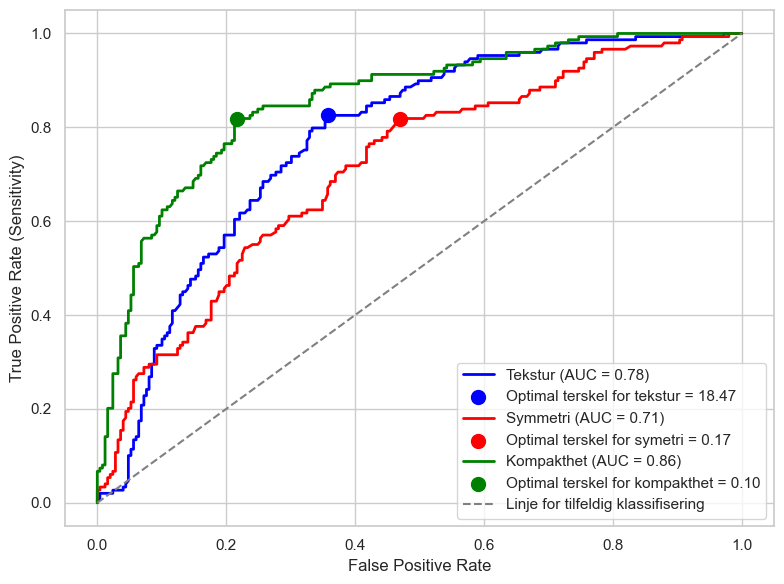

In [232]:
# Beregning av ROC-kurve og AUC for tekstur
fpr_texture, tpr_texture, thresholds_texture = roc_curve(df_kreft_ren_y_train["num_diagnosis"], df_kreft_ren_x_train["texture_mean"])
roc_auc_texture = auc(fpr_texture, tpr_texture)

# Beregning av ROC-kurve og AUC for symmetri
fpr_symmetry,tpr_symmetry, thresholds_symmetry =  roc_curve(df_kreft_ren_y_train["num_diagnosis"], df_kreft_ren_x_train["symmetry_mean"])
roc_auc_symmetry = auc(fpr_symmetry, tpr_symmetry)

# Beregning av ROC-kurve og AUC for kompakthet
fpr_compactness, tpr_compactness, thresholds_compactness = roc_curve(df_kreft_ren_y_train["num_diagnosis"], df_kreft_ren_x_train["compactness_mean"])
roc_auc_compactness = auc(fpr_compactness, tpr_compactness)


# Optimale terskelverdier
# Kalkulerer j-scores for hver av teksturvariablene
j_scores_texture = tpr_texture - fpr_texture
j_scores_symmetry = tpr_symmetry - fpr_symmetry
j_scores_compactness = tpr_compactness - fpr_compactness

# Indeks til individuelle j-scores
optimal_texture = np.argmax(j_scores_texture)
optimal_symmetry = np.argmax(j_scores_symmetry)
optimal_compactness = np.argmax(j_scores_compactness)

#Optimale terskelverdier for hver variabel
optimal_benchmark_texture = thresholds_texture[optimal_texture]
optimal_benchmark_symmetry = thresholds_symmetry[optimal_symmetry]
optimal_benchmark_compactness = thresholds_compactness[optimal_compactness]
f"Optimum terskel for tekstur er{optimal_benchmark_texture}"
f"Optimum terskel for tekstur er {optimal_symmetry}"
f"Optimum terskel for tekstur er{optimal_benchmark_compactness}"

# ROC curve
plt.figure(figsize=(8, 6))
# ROC og optimal terskel for tekstur
plt.plot(fpr_texture, tpr_texture, color='blue', lw=2, label=f'Tekstur (AUC = {roc_auc_texture:.2f})')
plt.scatter(fpr_texture[optimal_texture], tpr_texture[optimal_texture], color='blue',s = 100, label=f'Optimal terskel for tekstur = {optimal_benchmark_texture:.2f}')
# ROC og optimal terskel for tsymmetri
plt.plot(fpr_symmetry, tpr_symmetry, color='red', lw=2, label=f'Symmetri (AUC = {roc_auc_symmetry:.2f})')
plt.scatter(fpr_symmetry[optimal_symmetry], tpr_symmetry[optimal_symmetry], color="red",s = 100, label=f'Optimal terskel for symetri = {optimal_benchmark_symmetry:.2f}')
# ROC og optimal terskel for kompakthet
plt.plot(fpr_compactness, tpr_compactness, color='green', lw=2, label=f'Kompakthet (AUC = {roc_auc_compactness:.2f})')
plt.scatter(fpr_compactness[optimal_compactness], tpr_compactness[optimal_compactness], color='green', s = 100, label=f'Optimal terskel for kompakthet = {optimal_benchmark_compactness:.2f}')

# Linje for tilfeldig klassifisering
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Linje for tilfeldig klassifisering')

# Klargjøring

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('images/feature_engineering.png', dpi=300, bbox_inches='tight')
plt.show()

Ved bruk av ROC AUC fant vi terskel som vi vil bruke i omkodingen av tekstur variablene.
Tekstur: Terskel ved 18.47 (estimert treffsikkerhet: 78%).
Symmetri: Terskel ved 0.17 (estimert treffsikkerhet: 71%).
Kompakthet: Terskel ved 0.1(estimert treffsikkerhet: 86%).


#### 7.6.1 Omkoding av Tekstur

In [235]:
df_kreft_ren_x_train["texture_regression"] = df_kreft_ren_x_train["texture_mean"] > optimal_benchmark_texture
#Validering
print(df_kreft_ren_x_train["texture_regression"].describe(), df_kreft_ren_x_train["texture_regression"].value_counts())
print(df_kreft_ren_x_train[["texture_mean", "texture_regression"]].head(10))

count      398
unique       2
top       True
freq       211
Name: texture_regression, dtype: object texture_regression
True     211
False    187
Name: count, dtype: int64
     texture_mean  texture_regression
149         17.91               False
124         16.39               False
421         13.98               False
195         16.33               False
545         23.23                True
261         23.06                True
227         15.51               False
399         17.26               False
453         13.98               False
523         18.68                True


Alt stemmer!

#### 7.6.2 Omkoding av symmetri

In [238]:
df_kreft_ren_x_train["symmetry_regression"] = df_kreft_ren_x_train["symmetry_mean"] > optimal_benchmark_symmetry
#Validering
print(df_kreft_ren_x_train["symmetry_regression"].describe(), df_kreft_ren_x_train["symmetry_regression"].value_counts())
print(df_kreft_ren_x_train[["symmetry_mean", "symmetry_regression"]].head(10))

count      398
unique       2
top       True
freq       235
Name: symmetry_regression, dtype: object symmetry_regression
True     235
False    163
Name: count, dtype: int64
     symmetry_mean  symmetry_regression
149         0.1473                False
124         0.1422                False
421         0.2086                 True
195         0.1829                 True
545         0.1664                False
261         0.1564                False
227         0.1881                 True
399         0.1847                 True
453         0.1650                False
523         0.1714                False


Omkoding vellyket!

#### 7.6.3 Omkoding av kompakthet

In [241]:
df_kreft_ren_x_train["compactness_regression"] = df_kreft_ren_x_train["compactness_mean"] > optimal_benchmark_compactness
#Validering
print(df_kreft_ren_x_train["compactness_regression"].describe(), df_kreft_ren_x_train["compactness_regression"].value_counts())
print(df_kreft_ren_x_train[["compactness_mean", "compactness_regression"]].head(10))

count       398
unique        2
top       False
freq        223
Name: compactness_regression, dtype: object compactness_regression
False    223
True     175
Name: count, dtype: int64
     compactness_mean  compactness_regression
149           0.06376                   False
124           0.07325                   False
421           0.18360                    True
195           0.05366                   False
545           0.06747                   False
261           0.06290                   False
227           0.10960                    True
399           0.06232                   False
453           0.09242                   False
523           0.10700                    True


Omkoding vellyket!

Nå er alle utvalgte tekstur-variablene omkodet. Det gjenstår å slå dem sammen. Som sagt, fraktal dimensjon blir ikke inkludert som en del av teksturvariablene i prediksjonsmodellen siden siden søylediagrammet i EDA viste at kreftsvulster viste at det er ikke betydelig forskjell mellom godartede og ondartede kreftsvulster for denne variabelen.

In [244]:
df_kreft_ren_x_train["texture_attributes_regression"] = df_kreft_ren_x_train["texture_regression"] | df_kreft_ren_x_train["symmetry_regression"] | df_kreft_ren_x_train["compactness_regression"]
#Validering
print(df_kreft_ren_x_train["texture_attributes_regression"].value_counts())
df_kreft_ren_x_train[["texture_regression", "symmetry_regression", "compactness_regression", "texture_attributes_regression"]
].head(10)
                                                                                                                                 

texture_attributes_regression
True     313
False     85
Name: count, dtype: int64


,texture_regression,symmetry_regression,compactness_regression,texture_attributes_regression
149,False,False,False,False
124,False,False,False,False
421,False,True,True,True
195,False,True,False,True
545,True,False,False,True
261,True,False,False,True
227,False,True,True,True
399,False,True,False,True
453,False,False,False,False
523,True,False,True,True


Variabelen texture_attributes_regression er omkodet riktig!

### 7.7 Forberedelse datasett for logistisk regressjon

#### 7.7.1 Fjerning av unødvendige variabler fra treningsdatasettet:

In [248]:
df_kreft_ren_x_train.columns
df_kreft_ren_x_train = df_kreft_ren_x_train.drop([
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean',
    'concave points_mean', 'symmetry_mean',
    'concavity_regression',
    'concave_points_regression',
    'texture_regression', 'symmetry_regression', 'compactness_regression',
], axis=1)

#Validasjon
print(df_kreft_ren_x_train.shape)
print(df_kreft_ren_x_train.head(10))

(398, 4)
     radius_regression  smoothness_regression  concave_attributes_regression  \
149              False                  False                          False   
124              False                  False                           True   
421               True                   True                           True   
195              False                  False                          False   
545              False                  False                          False   
261               True                  False                          False   
227               True                  False                          False   
399              False                  False                          False   
453               True                   True                           True   
523              False                   True                          False   

     texture_attributes_regression  
149                          False  
124                          False  

Treningsdatasettet inneholder nå kun variablene som er relevante for prediksjonsmodellen.

### 7.7.2 Omkoding av testdatasettet slik at begge test- og treningsdatasettet har de samme uavhengige variablene


In [251]:
#Generering av variabler i test dataset
#Radius
df_kreft_ren_x_test["radius_regression"] = df_kreft_ren_x_test["radius_mean"] > optimal_benchmark_radius
#Glatthet
df_kreft_ren_x_test["smoothness_regression"] = df_kreft_ren_x_test["smoothness_mean"] > optimal_benchmark_smoothness
#Konkavitet
df_kreft_ren_x_test["concavity_regression"] = df_kreft_ren_x_test["concavity_mean"] > optimal_benchmark_concavity
#Konkave punkter
df_kreft_ren_x_test["concave_points_regression"] = df_kreft_ren_x_test["concave points_mean"] > optimal_benchmark_concave_points
#Tekstur
df_kreft_ren_x_test["texture_regression"] = df_kreft_ren_x_test["texture_mean"] > optimal_benchmark_texture
#Symmetri
df_kreft_ren_x_test["symmetry_regression"] = df_kreft_ren_x_test["symmetry_mean"] > optimal_benchmark_symmetry
#Kompakthet
df_kreft_ren_x_test["compactness_regression"] = df_kreft_ren_x_test["compactness_mean"] > optimal_benchmark_compactness

#Slå sammen overflateegenskaper-variablene
df_kreft_ren_x_test["concave_attributes_regression"] = df_kreft_ren_x_test["concavity_regression"] | df_kreft_ren_x_test["concave_points_regression"]
#Slå sammen teksturegenskaper-variablene
df_kreft_ren_x_test["texture_attributes_regression"] = df_kreft_ren_x_test["texture_regression"] | df_kreft_ren_x_test["symmetry_regression"] | df_kreft_ren_x_test["compactness_regression"]

#


Slå sammen variablene for overflate- og teksturegenskap

In [253]:
#overflateegenskaper-variablene
df_kreft_ren_x_test["concave_attributes_regression"] = df_kreft_ren_x_test["concavity_regression"] | df_kreft_ren_x_test["concave_points_regression"]
#teksturegenskaper-variablene
df_kreft_ren_x_test["texture_attributes_regression"] = df_kreft_ren_x_test["texture_regression"] | df_kreft_ren_x_test["symmetry_regression"] | df_kreft_ren_x_test["compactness_regression"]

Fjerning av unødvendige variabler fra treningsdatasettet:

In [255]:
df_kreft_ren_x_test.columns
df_kreft_ren_x_test = df_kreft_ren_x_test.drop([
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean',
    'concave points_mean', 'symmetry_mean',
    'concavity_regression',
    'concave_points_regression',
    'texture_regression', 'symmetry_regression', 'compactness_regression',
], axis=1)

#Validering
print(df_kreft_ren_x_test.shape)
print(df_kreft_ren_x_test.head(10))

(171, 4)
     radius_regression  smoothness_regression  concave_attributes_regression  \
204              False                   True                           True   
70                True                  False                           True   
131               True                   True                           True   
431              False                   True                           True   
540              False                   True                          False   
567               True                   True                           True   
369               True                   True                           True   
29                True                   True                           True   
81               False                   True                           True   
477              False                  False                          False   

     texture_attributes_regression  
204                           True  
70                            True  

Testdatasettet inneholder nå bare variablene som er relevante for prediksjonsmodellen.

# 8 Logistisk regressjon

#### 8.1. Betignelser for logistisk regressjon

Betignelser til logistisk regressjon er:

1 Binær avhengig variabel 
df_kreft_ren_y_train er en binær variabel (True/False), og kravet er oppfylt.

2 Uavhengige observasjoner
  Observasjonene er uavhengige, som krevd.
  
3 Ingen ekstreme verdier
  Alle prediktorer er binære, så ekstreme verdier er ikke et problem.
  
4 Tilstrekkelig utvalgsstørrelse- Dette må sjekkes.
   
5 Lineær sammenheng med log-odds
  Ikke relevant siden alle uavhengige variabler er binære.

6 Riktig modellspesifikasjon
  Variablene er valgt basert på fagkunnskap.
  
7 Ingen multikollinearitet Dette sjekkes videre med VIF.

#### 8.1.1 Multikolinearitet

<Axes: >

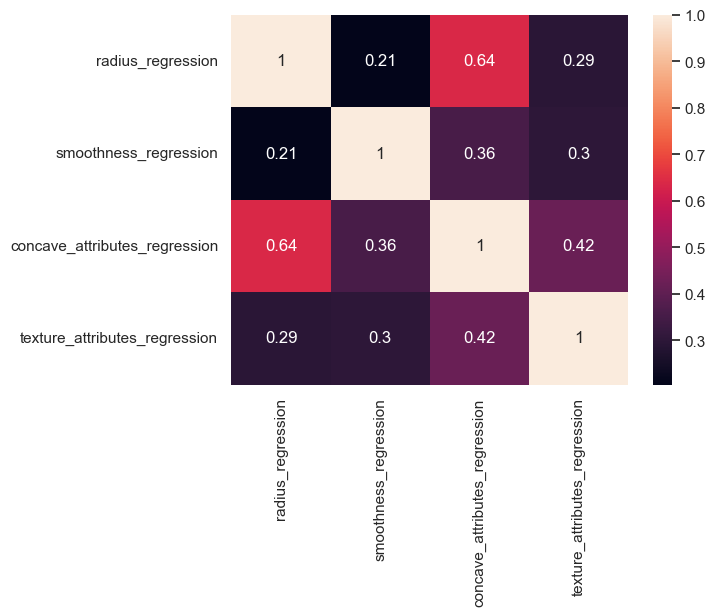

In [261]:
sns.heatmap(df_kreft_ren_x_train.corr(),annot = True)

Varmekartet viser at alle prediksjonsvariablene har lav til moderat korrelasjon.

In [263]:
# Beregn Variance Inflation Factor (VIF)

vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = df_kreft_ren_x_train.columns 
  
# Beregner VIF for hver variabel variabel
vif_scores["VIF Scores"] = [variance_inflation_factor(df_kreft_ren_x_train.values, i) for i in range(len(df_kreft_ren_x_train.columns))] 
  
display(vif_scores)

,Attribute,VIF Scores
0,radius_regression,0.017661
1,smoothness_regression,0.011747
2,concave_attributes_regression,0.020113
3,texture_attributes_regression,0.008988


 VIF tabellen viser at multikolinearitet ikke er en bekymring

#### 8.1.2 Tiksrekelig utvalgstørrelse

In [266]:

print(pd.crosstab(df_kreft_ren_x_train['radius_regression'], df_kreft_ren_y_train.values.ravel()))
print(pd.crosstab(df_kreft_ren_x_train['smoothness_regression'], df_kreft_ren_y_train.values.ravel()))
print(pd.crosstab(df_kreft_ren_x_train['concave_attributes_regression'], df_kreft_ren_y_train.values.ravel()))
print(pd.crosstab(df_kreft_ren_x_train['texture_attributes_regression'], df_kreft_ren_y_train.values.ravel()))

col_0                0    1
radius_regression          
False              217   25
True                32  124
col_0                    0   1
smoothness_regression         
False                  168  51
True                    81  98
col_0                            0    1
concave_attributes_regression          
False                          205    9
True                            44  140
col_0                            0    1
texture_attributes_regression          
False                           82    3
True                           167  146


Utvalgsstørrelsen kan være problematisk fordi vi har et utilstrekkelig antall data blant ondartede kreftsvulster som hadde lave verdier for teksturegenskaper og konkave egenskaper. Jeg vil likevel fortsette med logistisk regresjon. Dette kan imidlertid føre til en overestimering av innvirkningen fra andre variabler, spesielt radius som har sterk korrelasjon med utfallsvariabel og tilskrekelig antall data.

#### 8.2 Trening av Logistisk Regresjonsmodell

Tilpass (trene) logistisk regresjonsmodell til dataene

In [270]:
logistic_regression_model = LogisticRegression(random_state=42, solver='liblinear')
logistic_regression_model.fit(df_kreft_ren_x_train, df_kreft_ren_y_train.values.ravel())

LogisticRegression(random_state=42, solver='liblinear')

#### 8.3 Tolkning av resultater

Logistisk regresjon resultater

In [273]:
logit_model = sm.Logit(df_kreft_ren_y_train, sm.add_constant(df_kreft_ren_x_train).astype(int))
result = logit_model.fit()
print(result.summary())
#odds ratios
odds_ratios = np.exp(result.params)
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.271426
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:          num_diagnosis   No. Observations:                  398
Model:                          Logit   Df Residuals:                      393
Method:                           MLE   Df Model:                            4
Date:                Wed, 07 Jan 2026   Pseudo R-squ.:                  0.5895
Time:                        21:46:55   Log-Likelihood:                -108.03
converged:                       True   LL-Null:                       -263.17
Covariance Type:            nonrobust   LLR p-value:                 6.520e-66
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -5.1468      0.805     -6.397      0.

Resultatene fra den logistiske regresjonen viser at:
      Kreftsvulster med cellekjernestørrelse > 15.32µm  har 12x større odds for å være ondartede
Når det gjelder overflateegenskaper, svulster med:
    Konkavitet > 0.9 eller
    Antall konkave punkter > 0.05 har 18x høyere odds for å våre ondartede
    kreftsvulster med glatthet > 0.9 hadde 1.8x større odds for å være ondartede
Høyere teksturegenskaper hadde 4.5x større odds for å være ondartede. To sistenevnte var ikke statistisk signifikante.

Modellens Log-Likelihood på -108.03, kombinert med en Pseudo R-squared (McFadden's) på 0.5895, indikerer at modellen forklarer en svært stor del av variasjonen i utfallsvariabelen i datasettet vårt. Dette betyr at de uavhengige variablene er svært effektive til å skille mellom de to diagnoseutfallene.
Dette resultatet er naturlig når man har variabler som fungerer som nesten perfekte prediktorer i treningsdataene. Dette fenomenet kalles kvasi-perfekt separasjon. I vårt tilfelle er det spesielt radius_regression, concave_attributes_regression, og texture_attributes_regression (basert på tidligere resultater og diskusjon) som bidrar til de observerte høye oddsforholdene.
På grunn av deres sterke diskrimineringsevne ser disse variablene ut til å dominere modellen, og de bidrar med svært stor prediksjonsevne sammenlignet med de andre.Quasi separation vil si at modellet er altfor tilpasset for treningsdata. Implikasjoner og risiko for overtilpasning inkludererinflaterte oddsforhold: Modellen overvurderer effekten av prediktorer (f.eks. OR=18.46) eller redusert generaliserbarhet: Modellen kan prestere dårligere på nye data, spesielt hvis treningsdataene ikke er representative.
Nå skal vi teste regresjonsmodellen på testdataene for å vurdere dens generaliserbarhet og ytelse på ukjent data.

 #### 8.4 Model Evaluering

In [277]:
df_kreft_reg_y_predicted = logistic_regression_model.predict(df_kreft_ren_x_test)
display(df_kreft_reg_y_predicted)

#Beregn forvirringsmatrise
confusion_matrix = confusion_matrix(df_kreft_ren_y_test, df_kreft_reg_y_predicted)
print(confusion_matrix)

#Beregn ytelsesmetrikker
print(roc_auc_score(df_kreft_ren_y_test, df_kreft_reg_y_predicted))
print(precision_score(df_kreft_ren_y_test, df_kreft_reg_y_predicted))
f"sensitivty is {confusion_matrix[1,1]/ (confusion_matrix[1,1] + confusion_matrix[1,0])}"

array([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

[[103   5]
 [ 13  50]]
0.8736772486772486
0.9090909090909091


'sensitivty is 0.7936507936507936'

Mens treningsdataene viste tegn til kvasi-perfekt separasjon for enkelte variabler – noe som førte til svært høye oddsforhold og potensielt ustabile koeffisientestimater – generaliserer modellen likevel godt til ukjente data. Den sterke ytelsen på testsettet, med en ROC AUC på 0.87, presisjon på 0.9 og sensitivitet på 0.79, demonstrerer modellens robuste evne til å identifisere ondartede diagnoser. Dette indikerer at de konstruerte variablene, til tross for at de forårsaket separasjon, fanger opp svært signifikant diagnostisk informasjon. For en modell som skal settes i produksjon, kan man vurdere teknikker for å regularisere koeffisientene eller samle inn mer data for å redusere separasjonseffektene, men for dette prosjektet er resultatene lovende.

Precision score er 87% som indikerer at model treffer i 87% av tilfeller. 
Sensitivitet er 79 som jeg betrakter ganske lavt ganske lavt. Hvis modellet forutsier at kreftsvulst er godartet i stedet for ondartet selv om det er ondartet kan det ha alvorlige kliniske implikasjoner. Jeg trenger å sjekke hvor sannsynlig det er at modellen treffer ondartet kreftsvulst riktig.

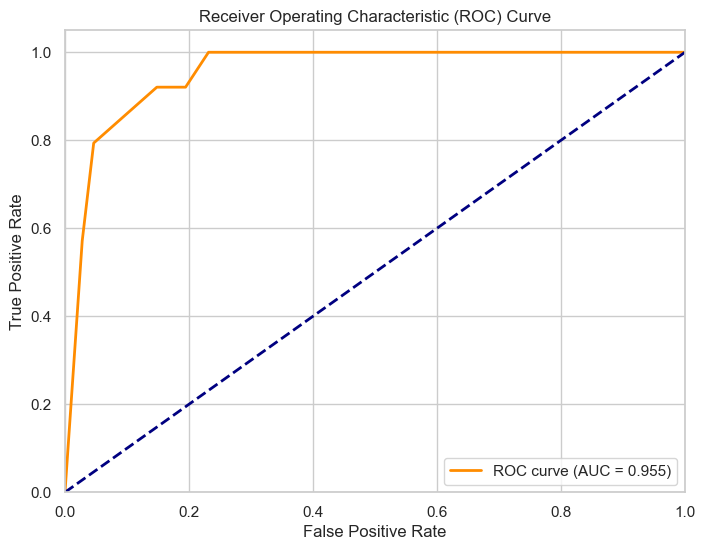

In [279]:
y_probs = logistic_regression_model.predict_proba(df_kreft_ren_x_test)[:, 1]

# Beregn ROC-kurven
fpr, tpr, thresholds = roc_curve(df_kreft_ren_y_test, y_probs)
roc_auc = roc_auc_score(df_kreft_ren_y_test, y_probs) # This line calculates the 0.94 AUC

# Plott ROC-kurven
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('images/ROCAUC.png', dpi=300, bbox_inches='tight')

ROC AUC-verdien på 0.955 er utmerket og indikerer en fremragende diskrimineringsevne. Dette betyr at modellen min er svært dyktig til å skille mellom ondartede og godartede diagnoser på tvers av alle mulige terskelverdier. Hvis vi tilfeldig velger en ondartet og en godartet svulst, har modellen hele 95.5% sjanse for å tildele den ondartede svulsten en høyere sannsynlighet enn den godartede. Denne verdien er den mest representative for modellens generelle evne til å skille mellom de to klassene, uavhengig av den spesifikke terskelen som ble brukt for å beregne presisjon og sensitivitet.

Mens treningsdataene viste tegn til kvasi-perfekt separasjon for enkelte variabler – noe som førte til svært høye oddsforhold og potensielt ustabile koeffisientestimater – generaliserer modellen likevel svært godt til ukjente data. Den fremragende ROC AUC på 0.955, samt den sterke presisjonen (0.87) og sensitiviteten (0.79) på testsettet, demonstrerer modellens robuste prediktive evne til å identifisere ondartede diagnoser. Dette indikerer at de konstruerte variablene, til tross for at de forårsaket separasjon, fanger opp svært signifikant diagnostisk informasjon som holder stand på nye data.

[3] https://jitc.bmj.com/content/11/3/e006092

### 9.Konklusjon og refleksjon over modellens ytelse og kliniske implikasjoner

Modellen min demonstrerer en fremragende samlet diskrimineringsevne med en høy ROC AUC på 0.955. Dette bekrefter dens evne til å skille effektivt mellom ondartede og godartede diagnoser.

Imidlertid er modellens nåværende sensitivitet på 79% for å oppdage ondartede tilfeller et område som krever videre vurdering. Dette betyr at modellen dessverre overseer mer enn 20% av faktiske krefttilfeller (falske negativer). Gitt de alvorlige kliniske implikasjonene av en oversett diagnose, er dette en kritisk metrikk å forbedre.

For en fremtidig produksjonsmodell ville det være nødvendig å undersøke metoder for å øke sensitiviteten, selv om dette skulle innebære en viss reduksjon i presisjonen (dvs. en økning i falske positiver). Dette kan oppnås ved å justere klassifiseringsterskelen eller ved å utforske andre modellforbedringer. For rammene av dette porteføljeprosjektet ligger imidlertid en slik optimalisering utenfor dets nåværende fokus.